Data: https://www.kaggle.com/datasets/pateljay731/panama-electricity-load-forecasting

# Import libraries

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
import pandas as pd
from time import time
import pickle as pkl
from keras.callbacks import EarlyStopping, Callback
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import math

# Download data

In [ ]:
import shutil
os.environ['KAGGLE_CONFIG_DIR'] = 'drive/MyDrive/Kaggle'
!kaggle datasets download -d pateljay731/panama-electricity-load-forecasting
!unzip -q panama-electricity-load-forecasting.zip -d data
!rm panama-electricity-load-forecasting.zip

Dataset URL: https://www.kaggle.com/datasets/pateljay731/panama-electricity-load-forecasting
License(s): unknown
  0% 0.00/2.98M [00:00<?, ?B/s]
100% 2.98M/2.98M [00:00<00:00, 113MB/s]


In [ ]:
# Read the train data
df = pd.read_csv("data/train.csv",
                 parse_dates=["datetime"],
                 index_col=["datetime"])

# EDA

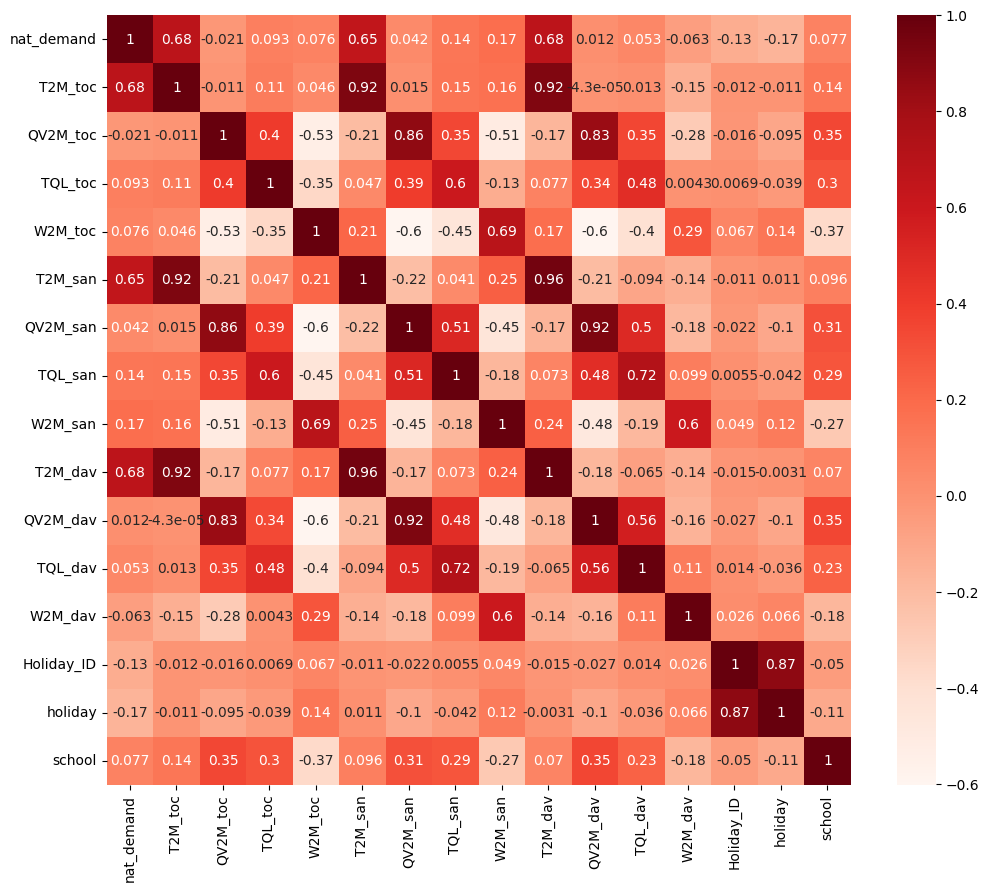

In [ ]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Feature Engineering

In [ ]:
# Feature selection
newDf = df[[c for c in df if c not in ['nat_demand']] + ['nat_demand']]
col = ['Holiday_ID','holiday', 'school']
newDf = newDf.drop(columns=col)

# Keep columns with higher absolute correlation of 50%
corr_matrix = newDf.corr()
high_corr_cols = corr_matrix[abs(corr_matrix['nat_demand']) > 0.5].index
data = newDf[high_corr_cols].copy()

# Scale data using MinMaxScaling
xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
newDf[[c for c in newDf if c not in ['nat_demand']]] = xScaler.fit_transform(newDf[[c for c in newDf if c not in ['nat_demand']]])
newDf[["nat_demand"]] = yScaler.fit_transform(newDf[["nat_demand"]])
newDfArray = newDf.to_numpy()

In [ ]:
import numpy as np

def split_2d_to_3d(array, window_size=10):
    # Get the shape of the original array
    rows, cols = array.shape

    # Calculate the number of windows
    num_windows = rows - window_size + 1

    # Use stride tricks to create a view with overlapping windows
    windows = np.lib.stride_tricks.sliding_window_view(array, (window_size, cols))

    # Reshape to get the desired 3D array
    return windows.reshape(num_windows, window_size, cols)

In [ ]:
# seriesToRollingWindowSeries
def time_series_to_time_window_series(time_series, window_size):
    """
    Takes a 2D array as input and returns a 3D array
    """

    # Get the shape of the original array
    rows, cols = time_series.shape

    # Calculate the number of windows
    num_windows = rows - window_size + 1

    # Use stride tricks to create a view with overlapping windows
    windows = np.lib.stride_tricks.sliding_window_view(
                time_series, (window_size, cols)
                )

    # Reshape to get the desired 3D array
    return windows.reshape(num_windows, window_size, cols)

In [ ]:
# array_2d = np.arange(60).reshape(20, 3)
# # array_2d
# X, y = prepare_time_series_data(array_2d, 5, 3)
# print(X)
# print(y)
# newDfArray = newDf.to_numpy()
# X, y = prepare_time_series_data(newDfArray, 5, 3)

In [ ]:
# test_size=0.1
# val_size=0.2

# # First split: separate test set
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# # Second split: separate validation set from training set
# val_size_adjusted = val_size / (1 - test_size)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted, shuffle=False)


In [ ]:
def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params):
    model = Sequential()
    current_params = 0

    # Heuristic to decide number of LSTM layers and units based on the total_trainable_params
    lstm_units = math.isqrt(total_trainable_params // 10)  # Initial units guess
    lstm_layers = max(2, int(math.log(total_trainable_params, 10) // 1))  # Minimum 2 layers
    min_units = 32  # Minimum units per layer

    # LSTM layer parameter calculation
    def calculate_lstm_params(units, input_dim):
        return 4 * (units * (units + input_dim + 1))

    # Dense layer parameter calculation
    def calculate_dense_params(units_in, units_out):
        return (units_in + 1) * units_out

    print(f"Building model with target {total_trainable_params} parameters")

    # First LSTM layer with input shape
    input_dim = X_train.shape[2]
    layer_params = calculate_lstm_params(lstm_units, input_dim)
    current_params += layer_params

    if current_params <= total_trainable_params:
        # model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, X_train.shape[2])))#, return_sequences=True))
        model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, X_train.shape[2]), return_sequences=True))
        print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
    else:
        print("Cannot add any layers without exceeding parameter limit.")
        return model

    # Add additional LSTM layers and reduce units progressively, checking parameter limit
    for i in range(1, lstm_layers - 2):
        lstm_units = max(min_units, int(lstm_units * 0.75))  # Gradually reduce units
        layer_params = calculate_lstm_params(lstm_units, lstm_units)  # Recurrent input dimension = lstm_units

        if current_params + layer_params <= total_trainable_params:
            model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=True))
            current_params += layer_params
            print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
        else:
            break  # Stop adding more LSTM layers if we exceed the limit

    # Modify the last layer to have return_sequences=False
    last_layer = model.layers[-1]
    if isinstance(last_layer, LSTM):
        new_config = last_layer.get_config()
        new_config['return_sequences'] = False
        new_lstm_layer = LSTM.from_config(new_config)
        model.pop()
        model.add(new_lstm_layer)
        print("Modified last LSTM layer to have return_sequences=False")
    else:
        print("The last layer is not an LSTM layer.")


    # Check if the last layer is an LSTM layer with return_sequences=True
    if isinstance(model.layers[-1], LSTM) and model.layers[-1].return_sequences:
        # Calculate parameters for a final LSTM layer without return_sequences
        lstm_units = max(min_units, int(lstm_units * 0.75))
        layer_params = calculate_lstm_params(lstm_units, lstm_units)

        if current_params + layer_params <= total_trainable_params:
            model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=False))
            current_params += layer_params
            print(f"Changed final LSTM layer with {lstm_units} units, params: {layer_params}")
        else:
            print("Cannot change a final LSTM layer without return_sequences due to parameter limit.")


    # Add Dense layer if within the parameter limit
    dense_units = max(min_units, lstm_units // 2)
    layer_params = calculate_dense_params(lstm_units, dense_units)

    if current_params + layer_params <= total_trainable_params:
        model.add(Dense(units=dense_units))#, activation='relu'))
        current_params += layer_params
        print(f"Added Dense layer with {dense_units} units, params: {layer_params}")

    # Add Dropout layer
    model.add(Dropout(0.2))  # Dropout layer doesn't add parameters

    # Output layer
    layer_params = calculate_dense_params(dense_units, ForecastHorizon)
    if current_params + layer_params <= total_trainable_params:
        model.add(Dense(ForecastHorizon))#, activation='linear'))
        current_params += layer_params
        print(f"Added Output Dense layer with {ForecastHorizon} units, params: {layer_params}")
    else:
        print(current_params + layer_params, total_trainable_params)
        print("Cannot add the final output layer without exceeding parameter limit.")

    print(f"Total parameters used: {current_params}/{total_trainable_params}")

    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True,)

    # Print summary for debugging
    model.summary()

    return model

In [ ]:
def plot_expected_predicted_data(
        expected_series, predicted_series,
        image_path=None, title="Expected vs Predicted"
        ):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_expected = expected_series[1:]
    plot_predicted = predicted_series[1:]
    ax.plot(plot_expected, label='Expected')
    ax.plot(plot_predicted, label='Predicted')
    ax.set_title(title)
    ax.legend()
    plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

def evaluate(self, expected, predicted):
    mse = mean_squared_error(expected, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(expected, predicted)
    r2 = r2_score(expected, predicted)
    mape = np.mean(np.abs((expected - predicted) / expected)) * 100
    explained_var = explained_variance_score(expected, predicted)

    # Printing the results
    # print("Evaluation Results:")
    # print(f"Mean Squared Error (MSE): {mse:.4f}")
    # print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    # print(f"Mean Absolute Error (MAE): {mae:.4f}")
    # print(f"R-squared (R²): {r2:.4f}")
    # print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    # print(f"Explained Variance: {explained_var:.4f}")

    # Optionally, return results in a dictionary for further analysis
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_var
    }

In [ ]:
def prepare_training_data(
        time_series, window_size, forecast_horizon,
        test_ratio, val_ratio, frequency=False
    ):

    # Separate features and target
    features = time_series#[:, :-1]  # All columns except the last
    target = time_series[:, -1].reshape(-1, 1)     # Last column

    # Use the provided function to create time windows for features
    X = time_series_to_time_window_series(features, window_size)

    # Prepare target values (y)
    y = time_series_to_time_window_series(target, forecast_horizon)

    # Adjust y to align with X and remove extra dimension
    X = X[:-forecast_horizon]
    y = y[window_size:]

    # X, y = prepare_time_series_data(array_2d, window_size, forecast_horizon)

    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
                                                    X, y, test_size=test_ratio,
                                                    shuffle=False
                                                )

    # Second split: separate validation set from training set
    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
                                            X_train_val, y_train_val,
                                            test_size=val_size_adjusted,
                                            shuffle=False
                                        )
    return X_train, y_train, X_val, y_val, X_test, y_test

#LSTM module

In [ ]:
class TimeLimitCallback(Callback):
    def __init__(self, time_limit):
        super(TimeLimitCallback, self).__init__()
        self.start_time = 0
        self.time_limit = time_limit

    def on_train_begin(self, logs=None):
        self.start_time = time()

    def on_epoch_end(self, epoch, logs=None):
        if time() - self.start_time > self.time_limit:
            self.model.stop_training = True
            print(f"Training stopped after {time() - self.start_time} seconds.")

In [ ]:
def lstm_driver(time_series_data, window_size, forecast_horizon, test_ratio=0.1, val_ratio=0.2, model_size=1000, epochs=20, train_time=1000, verbose=True):
    initialTime = time()
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio, frequency=False)
    model = build_balanced_lstm_model(window_size, X_train, forecast_horizon, model_size)
    # return
    earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
    callbacks = [earlyStop]
    if train_time > 0:
        time_limit_callback = TimeLimitCallback(time_limit=train_time)
        callbacks.append(time_limit_callback)
    if verbose:
        trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)#, verbose=0)
    else:
        trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=0)

    # print(self.X_test)
    predicted = model.predict(X_test)
    # print("Predicted:", predicted.shape)
    predicted = predicted[::forecast_horizon]
    predicted = predicted.reshape(predicted.shape[0]*predicted.shape[1], 1)
    predicted = yScaler.inverse_transform(predicted)

    expected = y_test[::forecast_horizon]
    # print("Expected:", predicted.shape)
    expected = expected.reshape(expected.shape[0]*expected.shape[1], 1)
    expected = yScaler.inverse_transform(expected)


    # print(self.X_test.shape, self.y_test.shape)
    # print(expected.shape, predicted.shape)

    mse = ((expected - predicted)**2).mean()
    totalTime = time() - initialTime
    information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
    return information

In [ ]:
newDfArraySample = newDfArray[:10000]

In [ ]:
results = lstm_driver(newDfArraySample, window_size=50, forecast_horizon=5, test_ratio=0.1, val_ratio=0.2, model_size=80000, epochs=20, train_time=10000, verbose=True)

Building model with target 80000 parameters
Added LSTM layer with 89 units, params: 36668
Added LSTM layer with 66 units, params: 35112
Modified last LSTM layer to have return_sequences=False
Added Dense layer with 33 units, params: 2211
Added Output Dense layer with 5 units, params: 170
Total parameters used: 74161/80000


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 89)              │          36,668 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 66)                  │          41,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 33)                  │           2,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 33)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,233 (313.41 KB)

 Trainable params: 80,233 (313.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 179s 818ms/step - loss: 0.1190 - val_loss: 0.0164
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 154s 706ms/step - loss: 0.0315 - val_loss: 0.0117
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 205s 721ms/step - loss: 0.0255 - val_loss: 0.0066
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 202s 720ms/step - loss: 0.0196 - val_loss: 0.0062
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 159s 730ms/step - loss: 0.0178 - val_loss: 0.0057
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 202s 732ms/step - loss: 0.0162 - val_loss: 0.0054
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 199s 718ms/step - loss: 0.0154 - val_loss: 0.0053
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 177s 813ms/step - loss: 0.0135 - val_loss: 0.0049
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 178s 704ms/step - loss: 0.0126 - val_loss: 0.0045
Epoch 10/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 155s 711ms/step - loss: 0.0115 - val_loss: 0.0040
Epoch 11/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 201s 710ms/step - loss: 0.0109 - val_loss: 0.0042
Epoch 12

In [ ]:
results.keys()

dict_keys(['expected', 'predicted', 'model', 'timeTaken', 'trainHistory', 'mse'])

In [ ]:
results.keys()

dict_keys(['expected', 'predicted', 'model', 'timeTaken', 'trainHistory', 'mse'])

In [ ]:
results.get("model")

<Sequential name=sequential_1, built=True>

In [ ]:
tempModel = results.get("model")

In [ ]:
tempModel.save("testmodel.keras")

In [ ]:
import keras
loaded_model = keras.saving.load_model("testmodel.keras")

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(newDfArraySample, window_size=50, forecast_horizon=5, test_ratio=0.1, val_ratio=0.2, frequency=False)
# window_size=50, forecast_horizon=5, test_ratio=0.1, val_ratio=0.2, model_size=80000, epochs=20, train_time=10000, verbose=True)
pred = loaded_model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 565ms/step


In [ ]:
predicted = pred[::5]
predicted = predicted.reshape(predicted.shape[0]*predicted.shape[1], 1)
predicted = yScaler.inverse_transform(predicted)

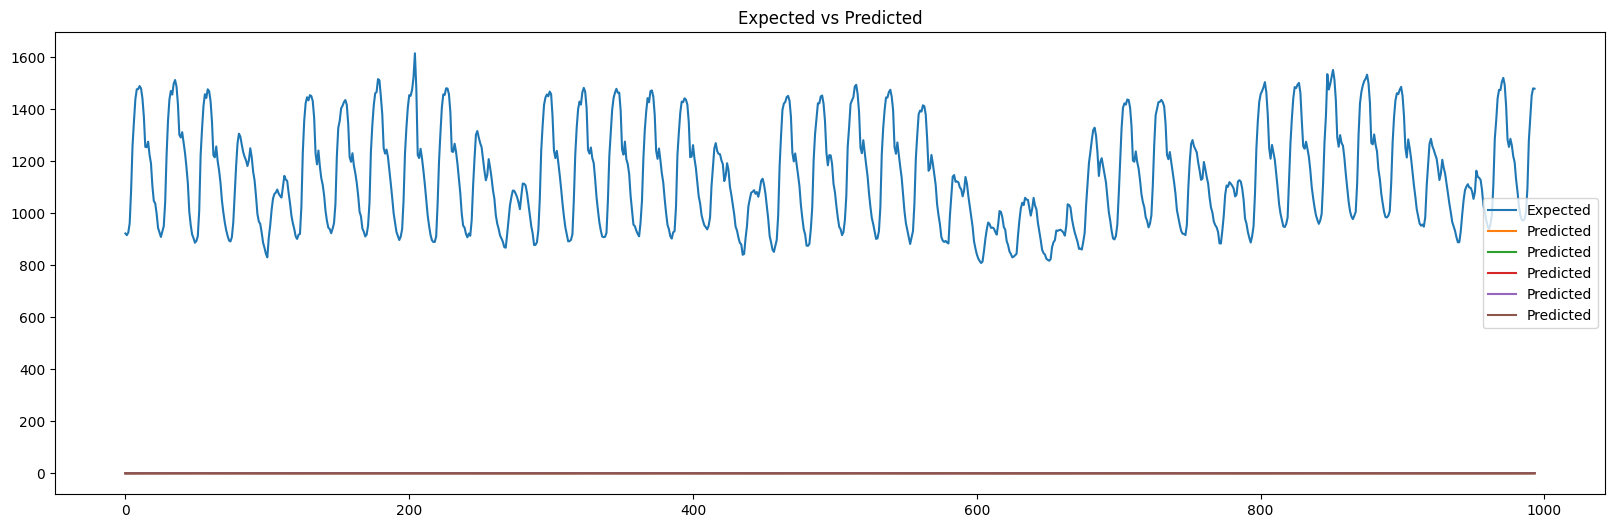

In [ ]:
from matplotlib import pyplot as plt

# plt.plot(results.get("expected"))
# plt.plot(results.get("predicted"))
# plt.show()

plot_expected_predicted_data(results.get("expected"), pred)

In [ ]:
Data = data.values[:10000]
WindowSize = 100
ForecastHorizon = 100
TrainRatio = 0.8
ValRatio = 0.1
LstmUnits = 100
DenseUnits = 100
Epochs = 20

In [ ]:
lstmModule.X_train.shape, lstmModule.X_test.shape

NameError: name 'lstmModule' is not defined

In [ ]:
DataSource = Data
lstmModule = LSTM_Module(DataSource, WindowSize, ForecastHorizon)
information = lstmModule.driver(TrainRatio, ValRatio, LstmUnits, DenseUnits, Epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,300 (282.42 KB)

 Trainable params: 72,300 (282.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2233 - val_loss: 0.0172
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0251 - val_loss: 0.0159
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0199 - val_loss: 0.0140
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0169 - val_loss: 0.0111
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0139 - val_loss: 0.0093
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0112 - val_loss: 0.0071
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/ste

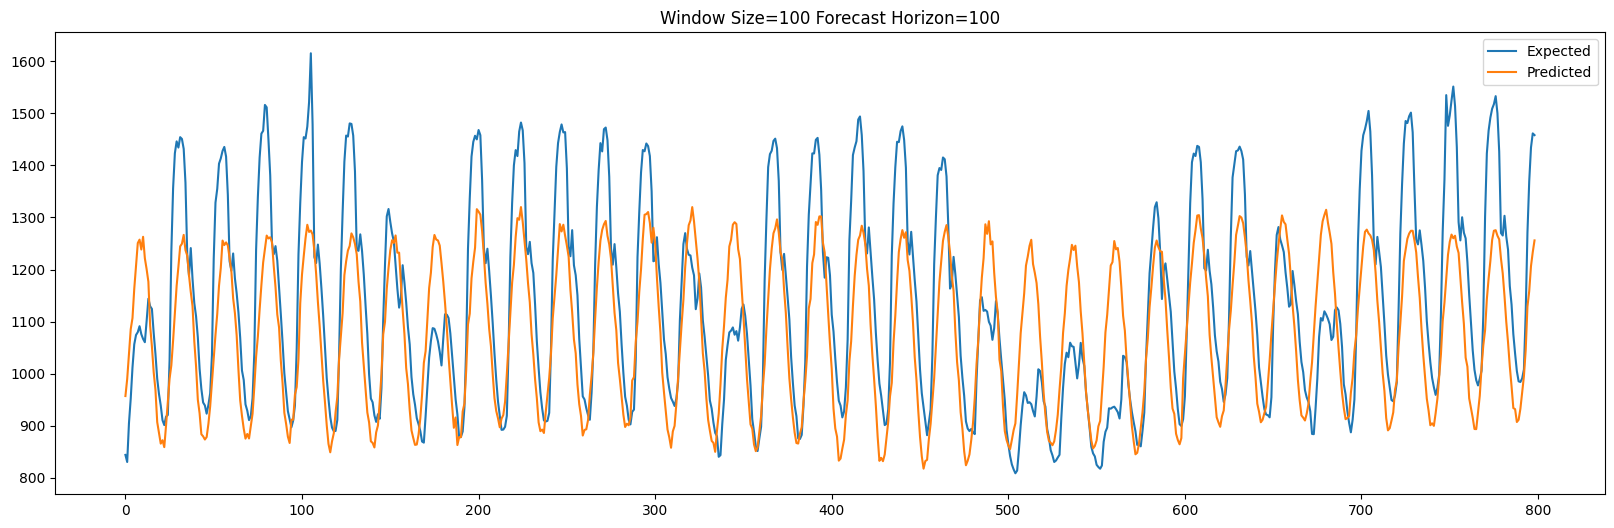

MSE=17927.328105175795


In [ ]:
lstmModule.evaluate(information["expected"], information["predicted"])

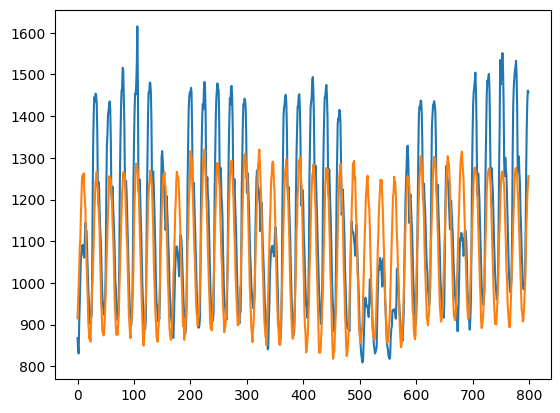

In [ ]:
plt.plot(information["expected"])
plt.plot(information["predicted"])
plt.show()

In [ ]:
# LstmUnits and dense Units - 1:10:1
# window size - 10:100:10
# ForecastHorizon - 5:25:5

In [ ]:
inputParameters = {
    "constants": {
        "Data": data.values[:10000],
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "Epochs": 20
    },
    "variables": {
        "WindowSize": [10, 100, 10],
        "ForecastHorizon": [5, 25, 5],
        "NeuronUnits": [1, 10, 1]
    }
}

In [ ]:
outputs = []
DataSource = data.values#[:10000]
windowSizeRange = range(inputParameters["variables"]["WindowSize"][0], inputParameters["variables"]["WindowSize"][1], inputParameters["variables"]["WindowSize"][2])
forecastHorizonRange = range(inputParameters["variables"]["ForecastHorizon"][0], inputParameters["variables"]["ForecastHorizon"][1], inputParameters["variables"]["ForecastHorizon"][2])
neuronUnitsRange = range(inputParameters["variables"]["NeuronUnits"][0], inputParameters["variables"]["NeuronUnits"][1], inputParameters["variables"]["NeuronUnits"][2])

totalScenarios = ((inputParameters["variables"]["WindowSize"][1]-inputParameters["variables"]["WindowSize"][0]) / inputParameters["variables"]["WindowSize"][2]+1) * \
                    ((inputParameters["variables"]["ForecastHorizon"][1]-inputParameters["variables"]["ForecastHorizon"][0]) / inputParameters["variables"]["ForecastHorizon"][2]+1) * \
                    ((inputParameters["variables"]["NeuronUnits"][1]-inputParameters["variables"]["NeuronUnits"][0]) / inputParameters["variables"]["NeuronUnits"][2]+1)

totalScenarios = int(totalScenarios)
index = 0
for windowSize in windowSizeRange:
    for forecastHorizon in forecastHorizonRange:
        for neuronUnits in neuronUnitsRange:
            print(index, "/", totalScenarios)
            params = {
                        "WindowSize": windowSize,
                        "ForecastHorizon": forecastHorizon,
                        "TrainRatio": 0.8,
                        "ValRatio": 0.1,
                        "LstmUnits": neuronUnits,
                        "DenseUnits": neuronUnits,
                        "Epochs": 20
                    }
            tmp = {"inputParameters": params, "runs":[]}
            for i in range(1):
                lstmModule = LSTM_Module(DataSource, params["WindowSize"], params["ForecastHorizon"])
                information = lstmModule.driver(params["TrainRatio"], params["ValRatio"], params["LstmUnits"], params["DenseUnits"], params["Epochs"])
                tmp["runs"].append(information)
            outputs.append(tmp)
            with open("outputs_"+str(index)+"_"+str(totalScenarios)+".pkl", "wb") as f:
                pkl.dump(outputs, f)
            # shutil.copy("outputs_"+str(index)+"_"+str(totalScenarios)+".pkl", "drive/MyDrive/CS297/Results/Data1/1")
            shutil.move("outputs_" + str(index) + "_" + str(totalScenarios) + ".pkl", "drive/MyDrive/CS297/Results/Data1/1")
            index+=1

Streaming output truncated to the last 5000 lines.
Model: "sequential_404"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_808 (LSTM)             (None, 30, 2)             128       
                                                                 
 lstm_809 (LSTM)             (None, 2)                 40        
                                                                 
 dense_957 (Dense)           (None, 2)                 6         
                                                                 
 dense_958 (Dense)           (None, 10)                30        
                                                                 
Total params: 204 (816.00 Byte)
Trainable params: 204 (816.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 8s 20ms/step - loss: 0.3992 - val_loss: 0

In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297

In [ ]:
print(information["timeTaken"])

145.2839856147766


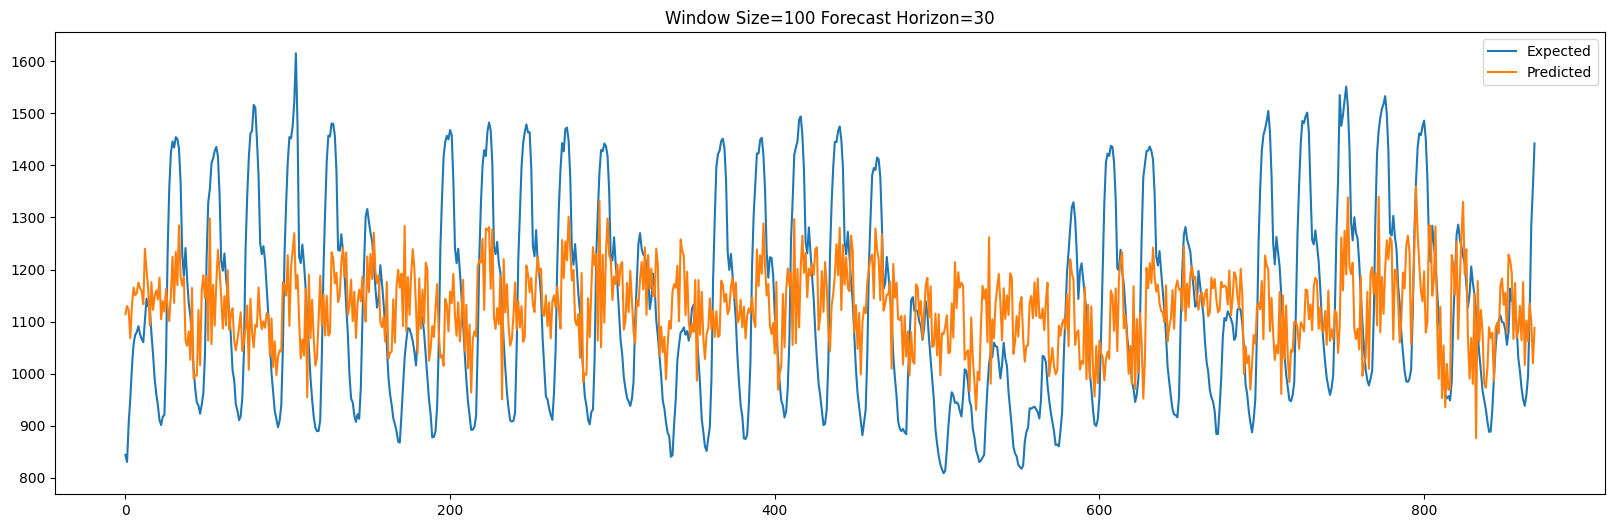

MSE=31149.647158347827


In [ ]:
lstmModule.evaluate(information["expected"], information["predicted"], yScaler)

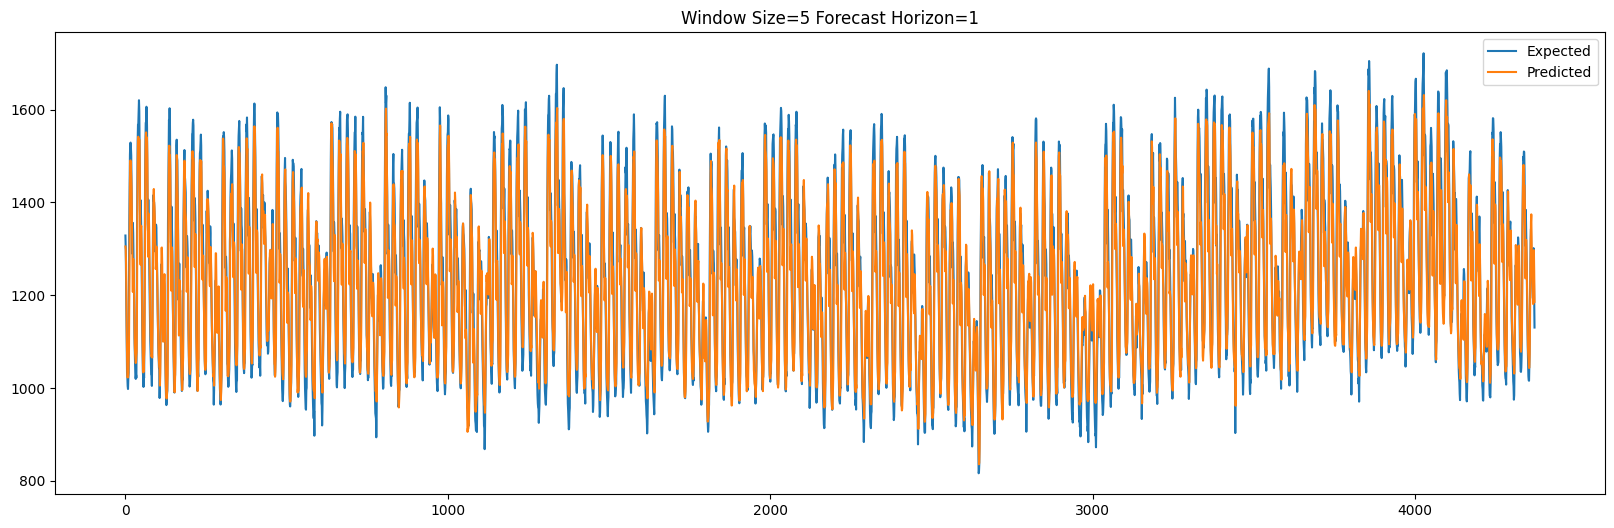

In [ ]:
lstmModule.plot_results(information["expected"], information["predicted"], title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=WindowSize, ForecastHorizon=ForecastHorizon))

In [ ]:
import pickle as pkl

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo1/LstmResults/1/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

36071.16542209931 30.723664712905883
----------------------------------------------------------------------------------------------------
37615.947307847455 78.34939131736755
----------------------------------------------------------------------------------------------------
37207.12388501633 156.0359920978546
----------------------------------------------------------------------------------------------------
37226.80310021913 30.89678626060486
----------------------------------------------------------------------------------------------------
188022.18735606788 119.84609913825989
----------------------------------------------------------------------------------------------------
nan 175.99480514526368
----------------------------------------------------------------------------------------------------


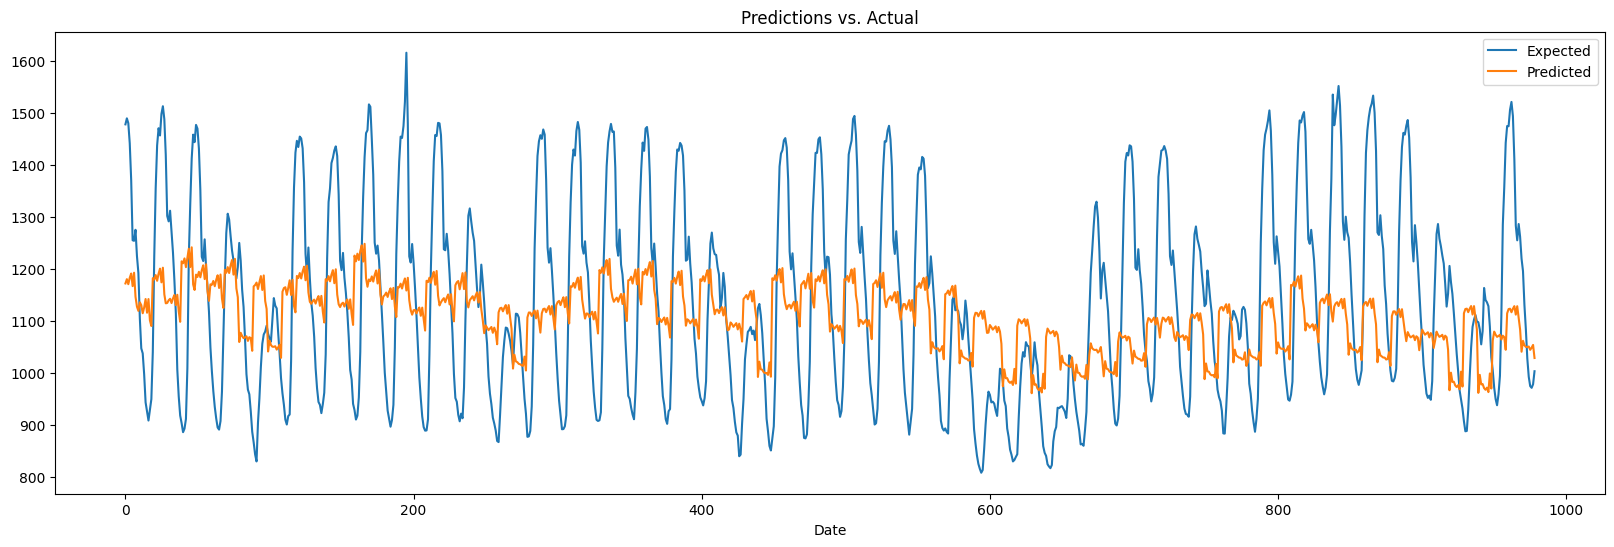

In [ ]:
plot_results(data[-3]["runs"][0]["expected"], data[-3]["runs"][0]["predicted"])

#Fourier-Informed DenseNet

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from keras.callbacks import Callback
from pprint import pprint

class TimeLimitCallback(Callback):
    def __init__(self, time_limit):
        super(TimeLimitCallback, self).__init__()
        self.start_time = 0
        self.time_limit = time_limit

    def on_train_begin(self, logs=None):
        self.start_time = time()

    def on_epoch_end(self, epoch, logs=None):
        if time() - self.start_time > self.time_limit:
            self.model.stop_training = True
            print(f"Training stopped after {time() - self.start_time} seconds.")


class FourierInformedTimeSeriesForecaster:

    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime):
        if ForecastHorizon>WindowSize:
            raise Exception("Forecast horizon must be lesser than window size")
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None
        self.MaskLower = MaskLower
        self.Univariate = Univariate
        self.TrainTime = TrainTime

    def seriesToRollingWindowSeries(self, series, windowSize):
        data = []
        for i in range(len(series)-windowSize):      # Each window
            features = []
            for featureNum in range(series.shape[-1]):        # Each feature
                features.append(series[i:i+windowSize, featureNum])
            data.append(features)
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        self.TargetComplexShape = ComplexValuedArray.shape
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        if self.MaskPercentage>0:
            if self.MaskLower:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
            else:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (0, self.WindowSize - len(frequencyMagnitudes)), 'constant')
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, maskPercentage=0, maskLower=True):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if maskPercentage>0:
                    if maskLower:
                        maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                    else:
                        maskIndex = int(len(frequencyMagnitudes)*(1-maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[:maskIndex]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0][-forecastHorizon:])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2, usePCA=True, pcaVarExpRatio=0.95, verbose=True, excludeTargetInTraining=False, windowedInput=False):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))
        if windowedInput:
            self.rollingWindowTimeSeries = self.TimeSeries
        else:
            self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage, maskLower=self.MaskLower)
        if self.Univariate:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:]
        elif excludeTargetInTraining:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize, :-1], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize, :-1], self.rollingWindowFrequencies[self.WindowSize:, -1]
        else:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:, -1]
            # self.X, self.y = self.originalX, self.originalY ############################################### No frequency domain
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if usePCA:
            pcaObj = PCA().fit(self.X)

            cumulative_variance_ratio = np.cumsum(pcaObj.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance_ratio >= pcaVarExpRatio) + 1

            covar_matrix = PCA(n_components = n_components)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.originalX_train, self.originalY_train = self.originalX[:trainSplitIndex], self.originalY[:trainSplitIndex]
        self.originalX_val, self.originaly_val = self.originalX[trainSplitIndex:valSplitIndex], self.originalY[trainSplitIndex:valSplitIndex]
        self.originalX_test, self.originalY_test = self.originalX[valSplitIndex:], self.originalY[valSplitIndex:]

        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]

        if verbose:
            verbose_info = {}
            verbose_info['originalX_test_shape'] = self.originalX_test.shape
            verbose_info['originalY_test_shape'] = self.originalY_test.shape
            verbose_info['X_test_shape'] = self.X_test.shape
            verbose_info['y_test_shape'] = self.y_test.shape
            pprint(verbose_info)


    def TrainSetup(self, hiddenLayers, hiddenUnits, verbose):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        if verbose:
            self.model.summary()


    def driver(self, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, usePCA=True, pcaVarExpRatio=0.95, verbose=True, targetScaler=None, excludeTargetInTraining=False):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio, usePCA=usePCA, pcaVarExpRatio=pcaVarExpRatio, verbose=verbose, excludeTargetInTraining=excludeTargetInTraining)
        self.TrainSetup(hiddenLayers, hiddenUnits, verbose)
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
        callbacks = [earlyStop]
        if self.TrainTime > 0:
            time_limit_callback = TimeLimitCallback(time_limit=self.TrainTime)
            callbacks.append(time_limit_callback)
        if verbose:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=callbacks)#, verbose=0)
        else:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=callbacks, verbose=0)
        totalTime = time() - initialTime

        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)    ######################### No frequencies
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)

        predicted = predicted.reshape(predicted.shape[0], 1)
        if targetScaler:
            predicted = targetScaler.inverse_transform(predicted)

        expected = self.rollingWindowTimeSeriesToTimeSeries(self.originalY_test, forecastHorizon=self.ForecastHorizon)
        expected = expected.reshape(expected.shape[0], 1)
        if targetScaler:
            expected = targetScaler.inverse_transform(expected)


        rmse = (((expected - predicted)**2).mean())**0.5

        information = {"expected": expected, "predicted": predicted, "timeTaken": totalTime, "rmse": rmse, "num_params": self.model.count_params(), "trainHistory":trainHistory.history}
        return information

In [ ]:
inputParameters = [
    {
        "Data": data.values[:10000],
        "WindowSize": 20,
        "ForecastHorizon": 20,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": data.values[:10000],
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": data.values[:10000],
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": data.values[:10000],
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": data.values[:10000],
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": data.values[:10000],
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    }
]

outputs = []

In [ ]:
params = {
        "Data": data.values[:10000],
        "WindowSize": 100,
        "ForecastHorizon": 100,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 3,
        "HiddenUnits": 100,
        "Epochs": 20,
        "Pca": True,
        "PcaVarExpRatio": 100
    }

In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"], False, False, 100)
information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], usePCA=params["Pca"], pcaVarExpRatio=params["PcaVarExpRatio"])

{'X_test_shape': (800, 1),
 'originalX_test_shape': (800, 4, 100),
 'originalY_test_shape': (800, 100),
 'y_test_shape': (800, 200)}


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 100)                 │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 200)                 │          20,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,600 (158.59 KB)

 Trainable params: 40,600 (158.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 10.0117 - val_loss: 1.8692
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8930 - val_loss: 0.5160
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5074 - val_loss: 0.5144
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5041 - val_loss: 0.5083
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5012 - val_loss: 0.5086
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5013 - val_loss: 0.5014
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4983 - val_loss: 0.5275
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5007 - val_loss: 0.5221
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4942 - val_loss: 0.5222
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5036 - val_loss: 0.5478
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4994 - val_loss: 0.5156
Epoch 11: early stopping
25/25 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

expected = information["expected"]
predicted = information["predicted"]

# Calculate regression metrics
mse = mean_squared_error(expected, predicted)
mae = mean_absolute_error(expected, predicted)
r2 = r2_score(expected, predicted)
rmse = np.sqrt(mse)

# Create a bar plot for the metrics
metrics_names = ['Mean Squared Error', 'Mean Absolute Error', 'R-squared', 'Root Mean Squared Error']
metrics_values = [mse, mae, r2, rmse]

print(metrics_names)
print(metrics_values)
# plt.figure(figsize=(10, 6))
# plt.bar(metrics_names, metrics_values, color='skyblue')
# plt.ylabel('Metric Value')
# plt.title('Regression Metrics')
# plt.show()

['Mean Squared Error', 'Mean Absolute Error', 'R-squared', 'Root Mean Squared Error']
[0.010121596157190067, 0.07958538096776095, 0.27120523611684666, 0.10060614373481407]


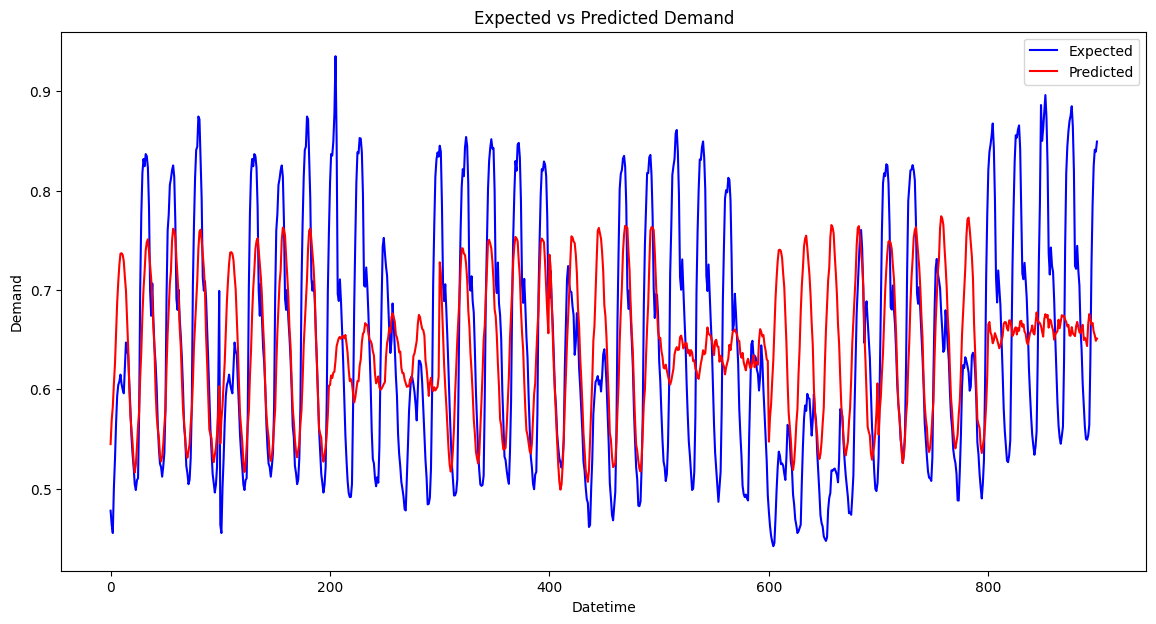

RMSE: 0.10060614373481407


In [ ]:
expected = information["expected"]
predicted = information["predicted"]
# Plot expected vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(expected, label='Expected', color='blue')
plt.plot(predicted, label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Expected vs Predicted Demand')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(expected, predicted))
print(f'RMSE: {rmse}')

In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                        hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], pca=params["Pca"], pcaComponents=params["PcaComponents"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

TypeError: FourierInformedTimeSeriesForecaster.__init__() missing 3 required positional arguments: 'MaskLower', 'Univariate', and 'TrainTime'

In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo1/FourierResults/1_1

In [ ]:
predicted = ft.model.predict(ft.X_test)
predicted = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, ft.TargetComplexShape)
predicted = ft.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=10)
predicted = predicted.reshape(len(predicted), 1)
predicted = yScaler.inverse_transform(predicted)

expected = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(ft.y_test, ft.TargetComplexShape)
expected = ft.rollingWindowTimeSeriesToTimeSeries(expected, forecastHorizon=10)
expected = expected.reshape(len(expected), 1)
expected = yScaler.inverse_transform(expected)

plot_results(expected, predicted, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=WindowSize, ForecastHorizon=ForecastHorizon))
mse = ((expected- predicted)**2).mean()
print("RMSE:", mse**0.5)

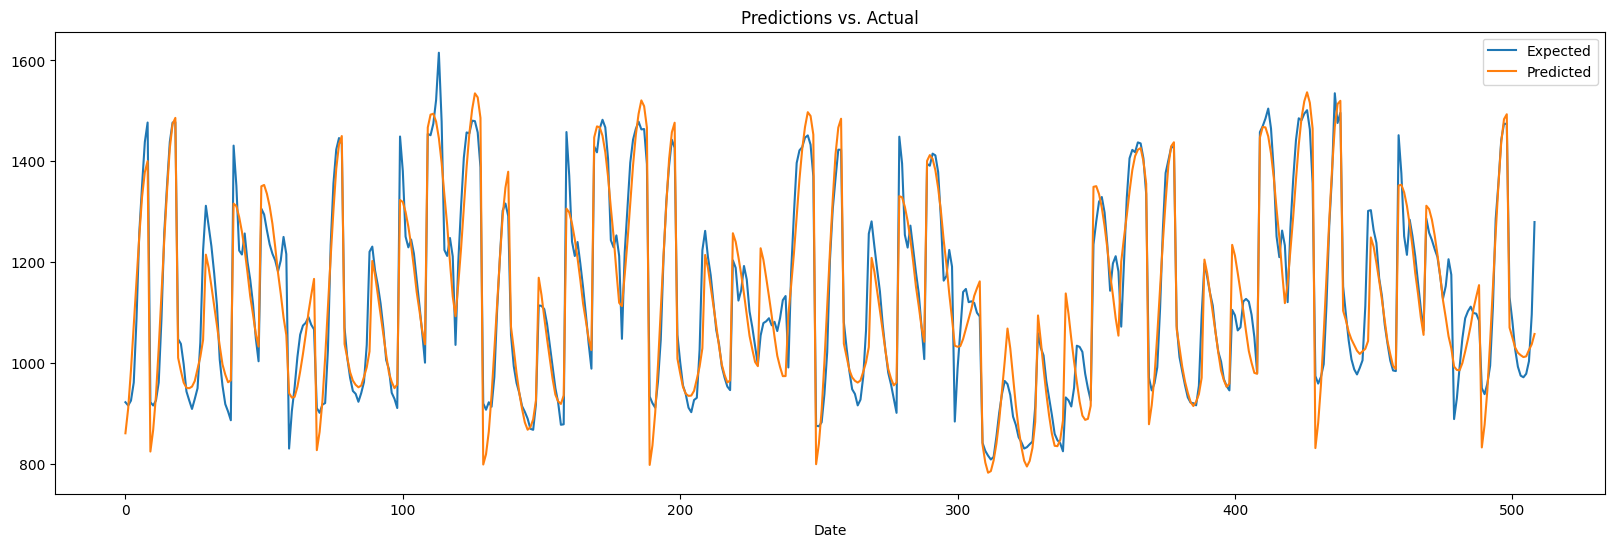

In [ ]:
plot_results(information["expected"], information["predicted"])

In [ ]:
def plot_results(actual, preds, image_path=None, title_suffix=None):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_actual = actual[1:]
    plot_preds = preds[1:]
    ax.plot(plot_actual, label='Expected')
    ax.plot(plot_preds, label='Predicted')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
        ax.set_title(title_suffix)
    ax.set_xlabel('Date')
    # ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

In [ ]:
import os
import pickle as pkl

In [ ]:
# for i in range(6):
data = None
with open("outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs_5_6.pkl'

In [ ]:
len(data)

1

In [ ]:
for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

8170.798531595184 21.437208652496338
----------------------------------------------------------------------------------------------------
32972.05686558122 27.371896505355835
----------------------------------------------------------------------------------------------------
40799.91221667244 30.23226127624512
----------------------------------------------------------------------------------------------------
3744.299717577076 26.26370792388916
----------------------------------------------------------------------------------------------------
34467.870009034275 26.370360374450684
----------------------------------------------------------------------------------------------------
51849.64453733088 32.4173469543457
----------------------------------------------------------------------------------------------------


In [ ]:
# for i in range(6):
data = None
with open("drive/MyDrive/CS297/LstmResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

In [ ]:
for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

36071.16542209931 30.723664712905883
----------------------------------------------------------------------------------------------------
37615.947307847455 78.34939131736755
----------------------------------------------------------------------------------------------------
37207.12388501633 156.0359920978546
----------------------------------------------------------------------------------------------------
37226.80310021913 30.89678626060486
----------------------------------------------------------------------------------------------------
188022.18735606788 119.84609913825989
----------------------------------------------------------------------------------------------------
nan 175.99480514526368
----------------------------------------------------------------------------------------------------


In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo1/FourierResults/1_1/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

47128.348921713274 20.34102067947388
----------------------------------------------------------------------------------------------------
79615.88763738684 23.821702480316162
----------------------------------------------------------------------------------------------------
81911.50181202113 26.720273303985596
----------------------------------------------------------------------------------------------------
39039.49874503657 23.135225009918212
----------------------------------------------------------------------------------------------------
89353.8706823714 26.85137548446655
----------------------------------------------------------------------------------------------------
68015.59036931478 28.73043155670166
----------------------------------------------------------------------------------------------------


In [ ]:
from matplotlib import pyplot as plt

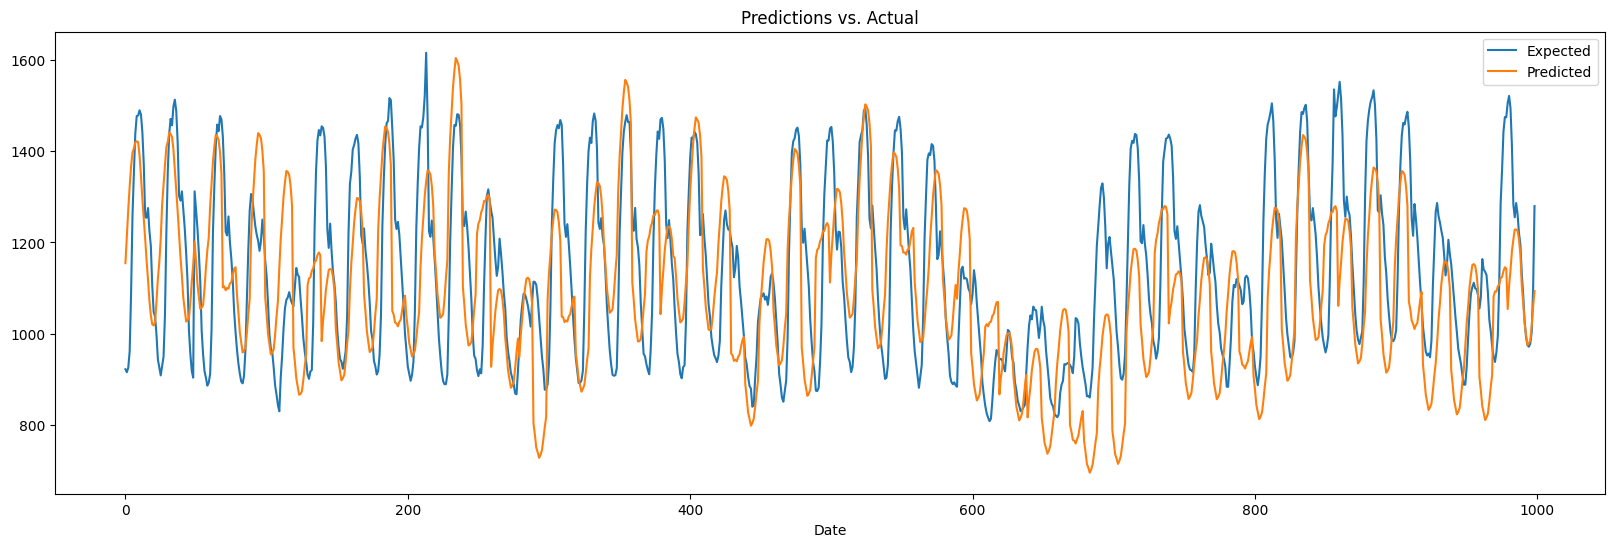

In [ ]:
plot_results(data[-2]["runs"][0]["expected"], data[-2]["runs"][0]["predicted"])

In [ ]:
# !unzip drive/MyDrive/CS297/Demo1/LstmResults/2/lstmResults.zip -d lstmResults
!unzip drive/MyDrive/CS297/Demo1/FourierResults/2/fourierResults.zip -d fourierResults

Archive:  drive/MyDrive/CS297/Demo1/FourierResults/2/fourierResults.zip
  inflating: fourierResults/outputs_0_500.pkl  
  inflating: fourierResults/outputs_100_500.pkl  
  inflating: fourierResults/outputs_101_500.pkl  
  inflating: fourierResults/outputs_102_500.pkl  
  inflating: fourierResults/outputs_103_500.pkl  
  inflating: fourierResults/outputs_104_500.pkl  
  inflating: fourierResults/outputs_105_500.pkl  
  inflating: fourierResults/outputs_106_500.pkl  
  inflating: fourierResults/outputs_107_500.pkl  
  inflating: fourierResults/outputs_108_500.pkl  
  inflating: fourierResults/outputs_109_500.pkl  
  inflating: fourierResults/outputs_10_500.pkl  
  inflating: fourierResults/outputs_110_500.pkl  
  inflating: fourierResults/outputs_111_500.pkl  
  inflating: fourierResults/outputs_112_500.pkl  
  inflating: fourierResults/outputs_113_500.pkl  
  inflating: fourierResults/outputs_114_500.pkl  
  inflating: fourierResults/outputs_115_500.pkl  
  inflating: fourierResults/out

In [ ]:
import os
import pickle as pkl

In [ ]:
# outputFiles = os.listdir("lstmResults")
outputs = None
with open("drive/MyDrive/CS297/Demo1/LstmResults/2/outputs_323_500.pkl", "rb") as f:
    outputs = pkl.load(f)
lstmData = {'WindowSize':[], 'ForecastHorizon':[], 'TimeTaken':[], 'Error':[], "Size": []}
for output in outputs:
    lstmData["WindowSize"].append(output["inputParameters"]["WindowSize"])
    lstmData["Size"].append(output["runs"][0]["num_params"])
    lstmData["ForecastHorizon"].append(output["inputParameters"]["ForecastHorizon"])
    lstmData["TimeTaken"].append(output["runs"][0]["timeTaken"])
    lstmData["Error"].append(output["runs"][0]["mse"])

import pandas as pd

lstmDf = pd.DataFrame.from_dict(lstmData)

# outputFiles = os.listdir("lstmResults")
outputs = None
with open("drive/MyDrive/CS297/Demo1/FourierResults/2/outputs.pkl", "rb") as f:
    outputs = pkl.load(f)
fourierData = {'WindowSize':[], 'ForecastHorizon':[], 'TimeTaken':[], 'Error':[], "Size": []}
for output in outputs:
    fourierData["WindowSize"].append(output["inputParameters"]["WindowSize"])
    fourierData["Size"].append(output["runs"][0]["num_params"])
    fourierData["ForecastHorizon"].append(output["inputParameters"]["ForecastHorizon"])
    fourierData["TimeTaken"].append(output["runs"][0]["timeTaken"])
    fourierData["Error"].append(output["runs"][0]["mse"])

import pandas as pd

fourierDf = pd.DataFrame.from_dict(fourierData)

In [ ]:
lstmDf

WindowSize  ForecastHorizon  TimeTaken          Error  Size
0            10                5  15.261769   89298.671662    72
1            10                5  14.717436   34661.273816   149
2            10                5  14.680193   33184.399896   236
3            10                5  15.442641   38456.836766   333
4            10                5  15.564718   32685.257983   440
..          ...              ...        ...            ...   ...
319          90               20  74.468796   36682.860665   530
320          90               20  73.154282   32951.303878   662
321          90               20  76.860178  733535.970429   804
322          90               20  76.575055   30990.179197   956
323          90               20  78.361382   30923.711424  1118

[324 rows x 5 columns]

In [ ]:
fourierDf

WindowSize  ForecastHorizon  TimeTaken          Error  Size
0            10                5  16.473013   14625.872833    57
1            10                5  12.707135  164227.224305   100
2            10                5  21.335745   13736.066367   155
3            10                5  10.843271   14350.847890   228
4            10                5  10.277485    3418.669373   325
..          ...              ...        ...            ...   ...
319          90               20  25.284927   29011.804379  1610
320          90               20  25.038441   39157.070446  1962
321          90               20  25.442142   15344.935818  2350
322          90               20  25.893958   22995.529818  2780
323          90               20  27.532963   15438.185418  3258

[324 rows x 5 columns]

In [ ]:
lstmGrouped = lstmDf.groupby(['WindowSize', "ForecastHorizon"])
fourierGrouped = fourierDf.groupby(['WindowSize', "ForecastHorizon"])

In [ ]:
lstmGrouped = lstmDf.groupby(['WindowSize', "ForecastHorizon"])
fourierGrouped = fourierDf.groupby(['WindowSize', "ForecastHorizon"])

In [ ]:
for g in groups:
    print(g)

(10, 5)
(10, 10)
(10, 15)
(10, 20)
(20, 5)
(20, 10)
(20, 15)
(20, 20)
(30, 5)
(30, 10)
(30, 15)
(30, 20)
(40, 5)
(40, 10)
(40, 15)
(40, 20)
(50, 5)
(50, 10)
(50, 15)
(50, 20)
(60, 5)
(60, 10)
(60, 15)
(60, 20)
(70, 5)
(70, 10)
(70, 15)
(70, 20)
(80, 5)
(80, 10)
(80, 15)
(80, 20)
(90, 5)
(90, 10)
(90, 15)
(90, 20)


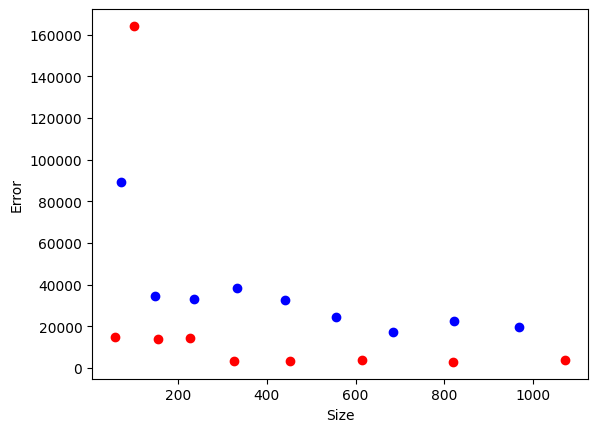

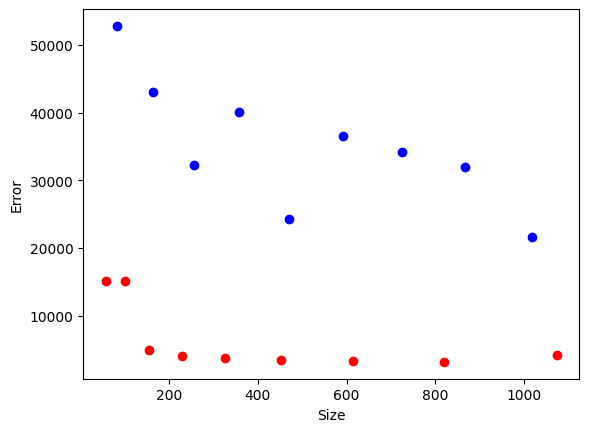

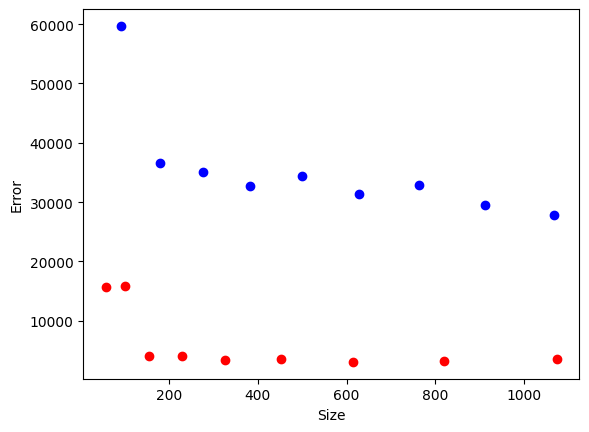

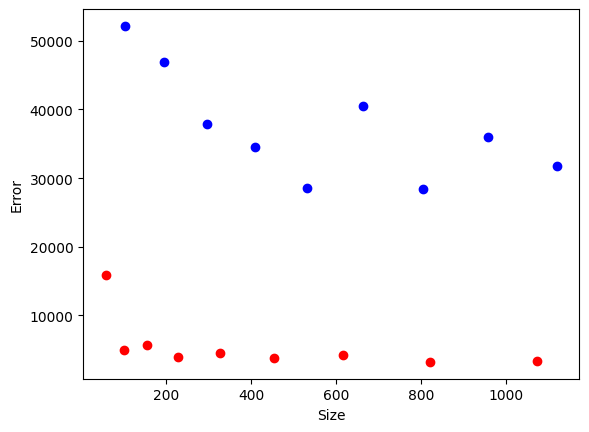

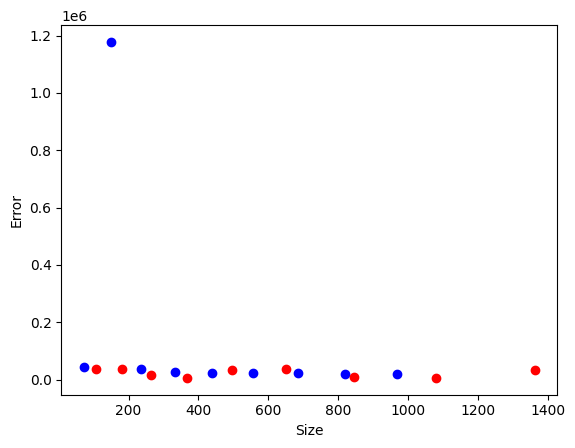

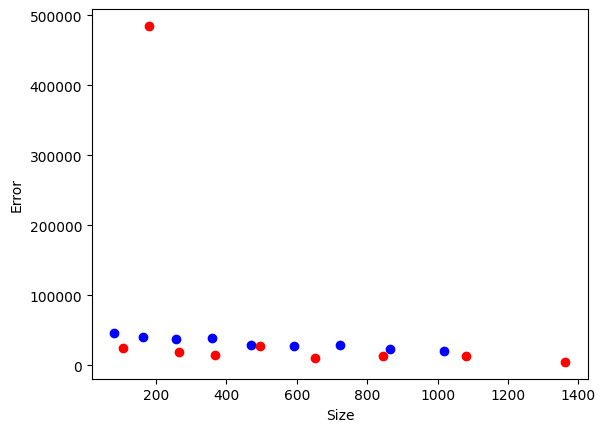

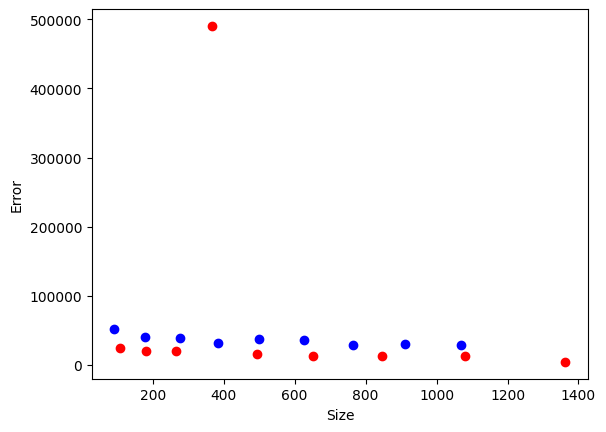

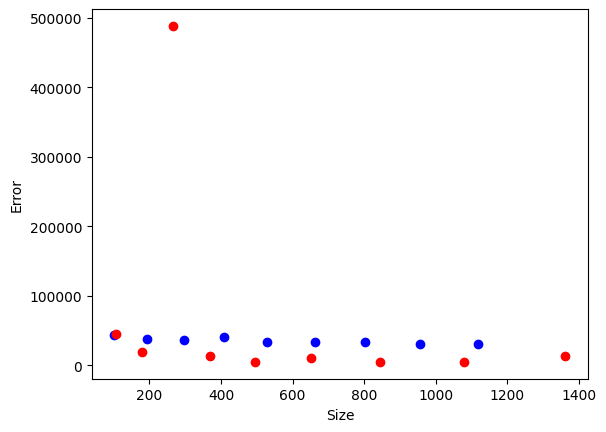

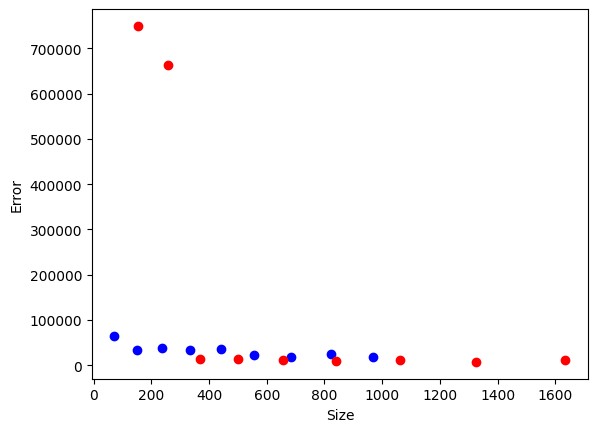

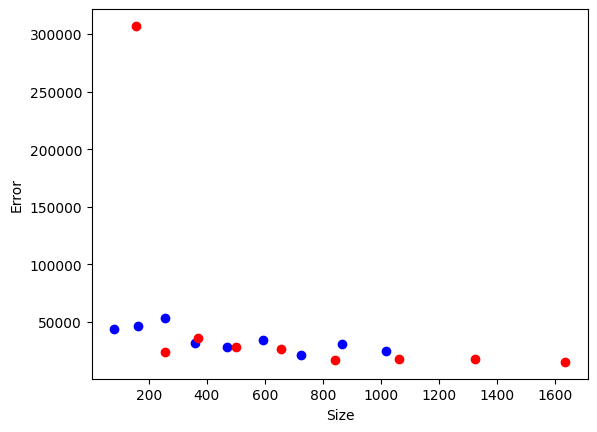

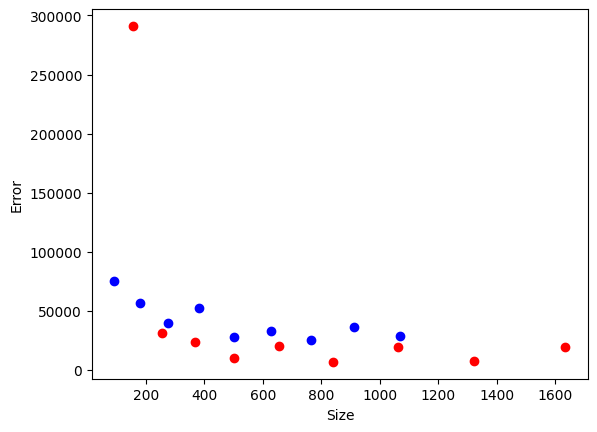

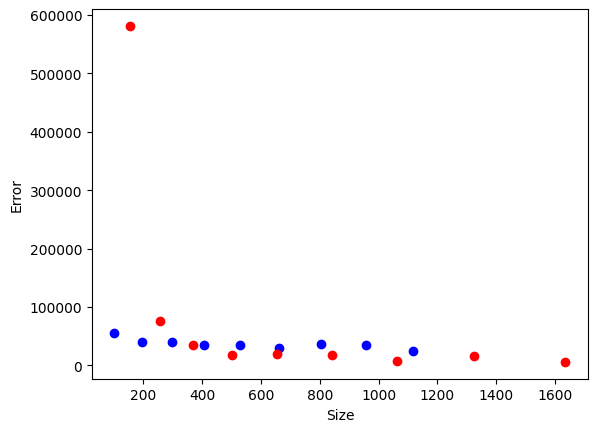

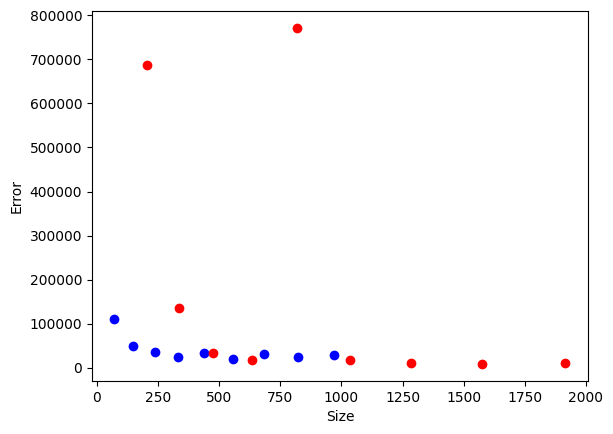

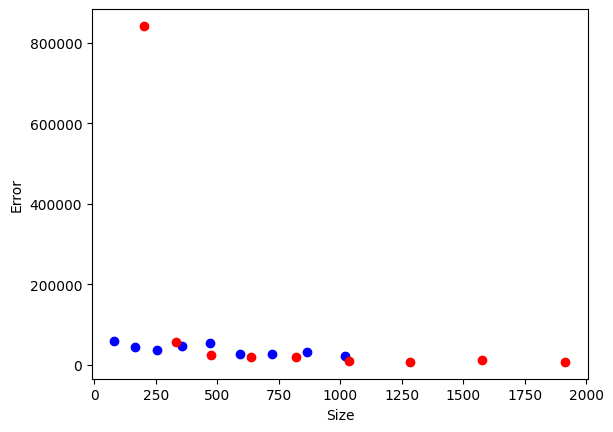

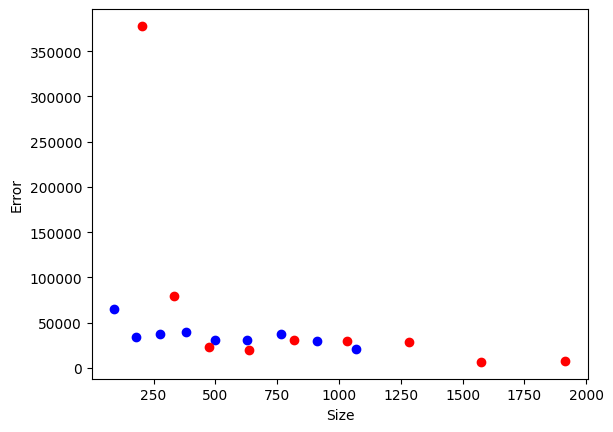

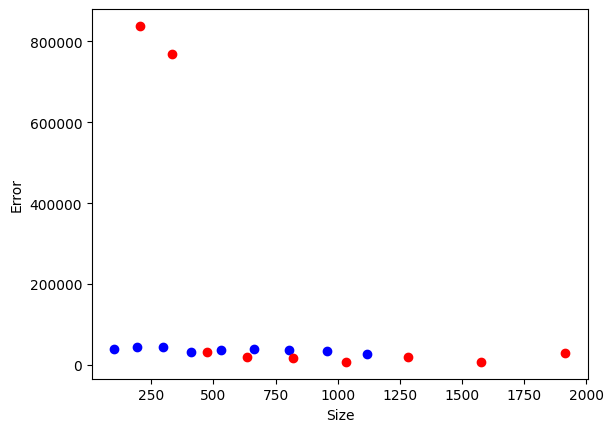

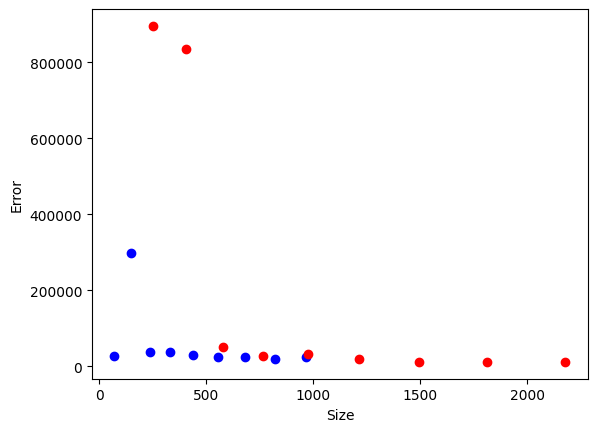

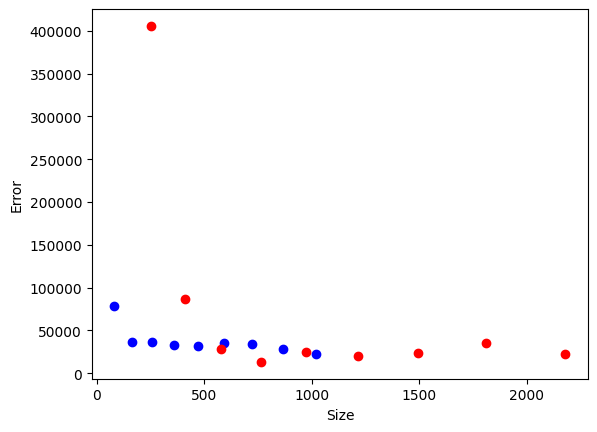

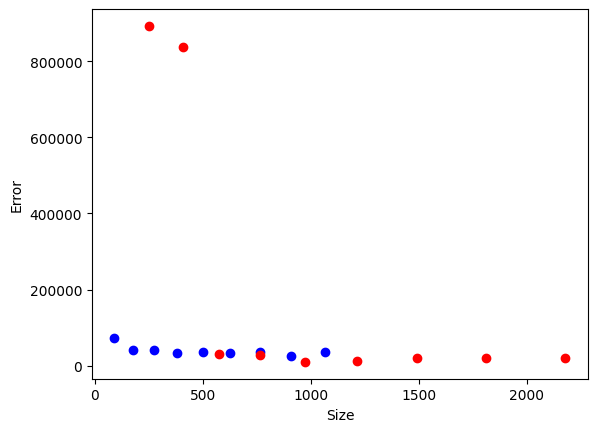

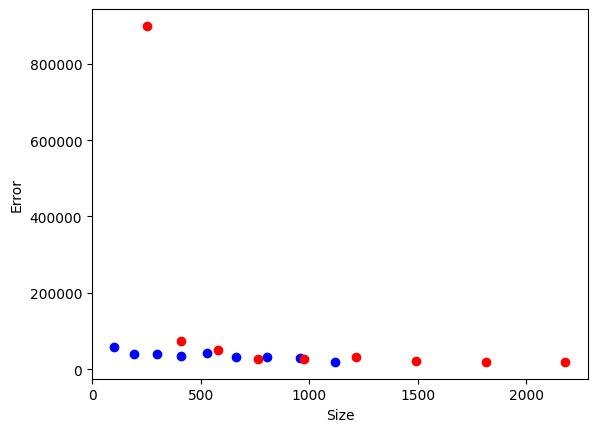

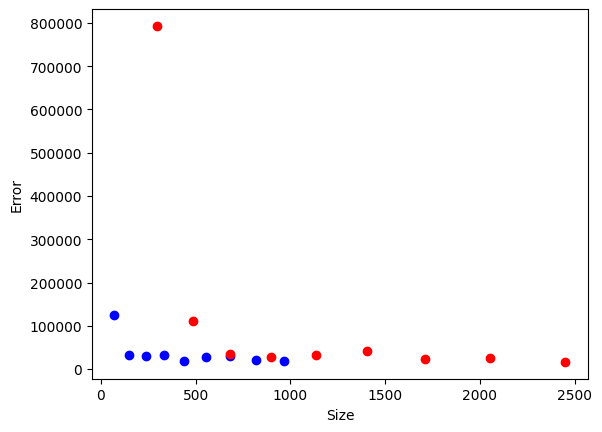

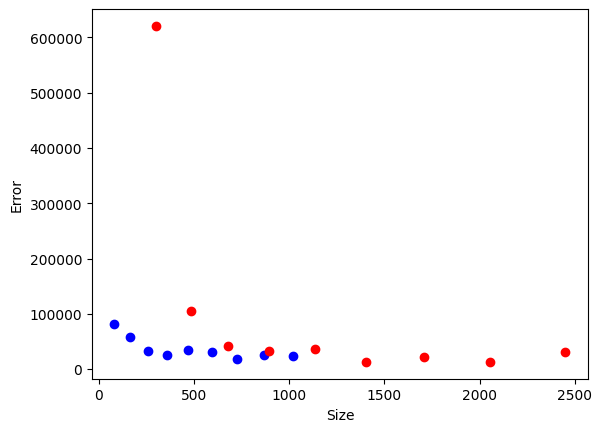

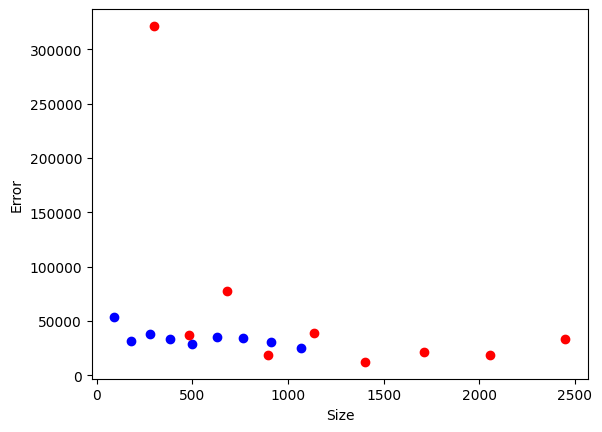

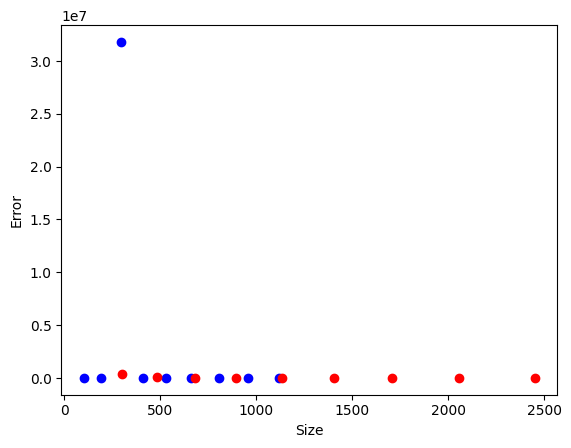

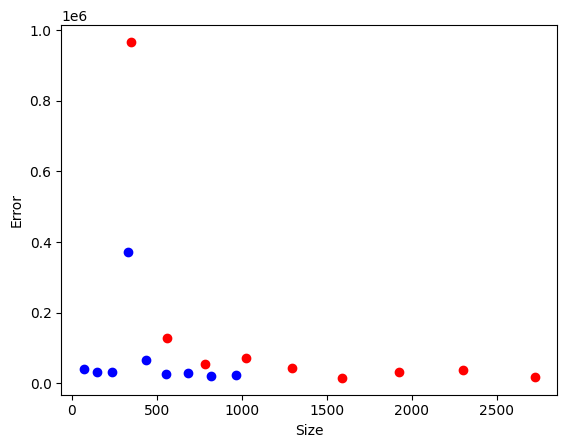

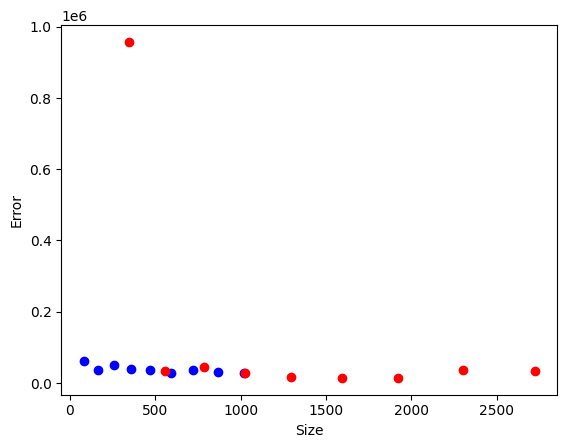

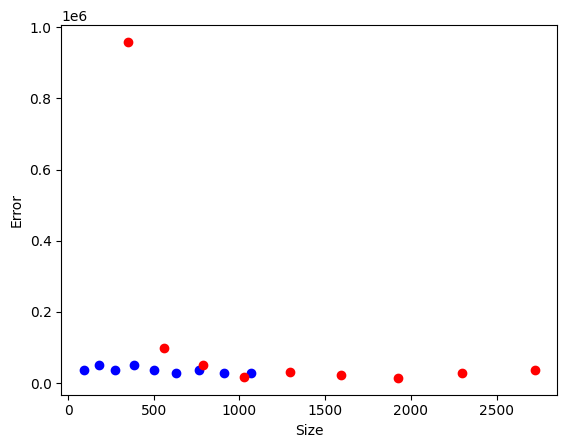

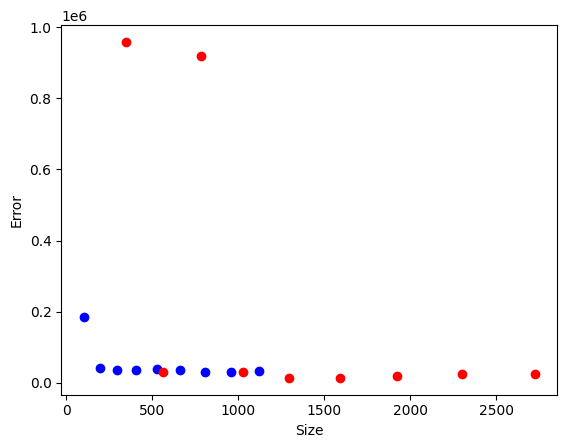

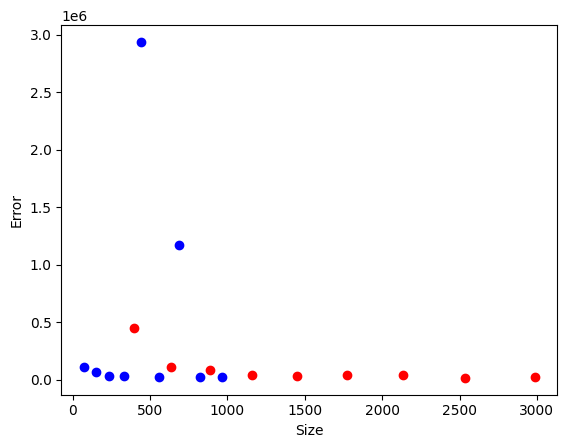

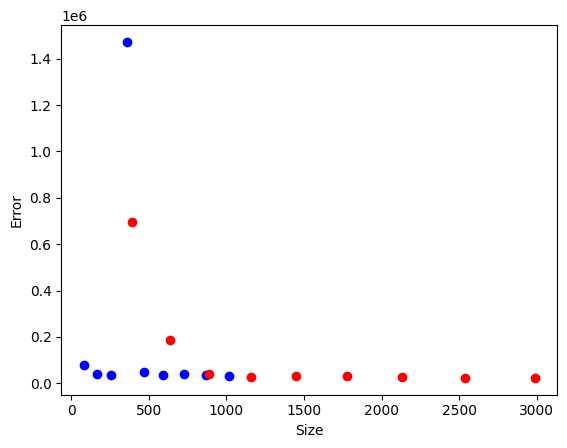

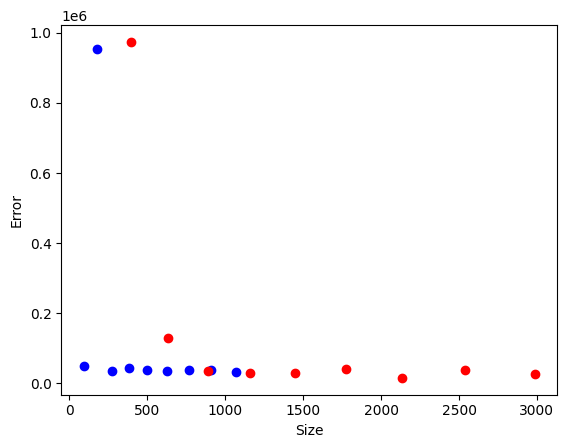

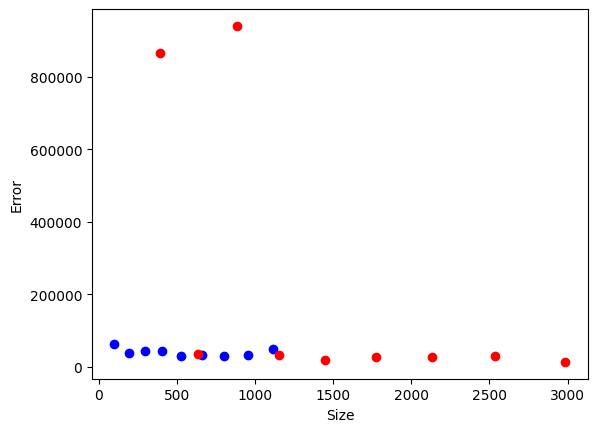

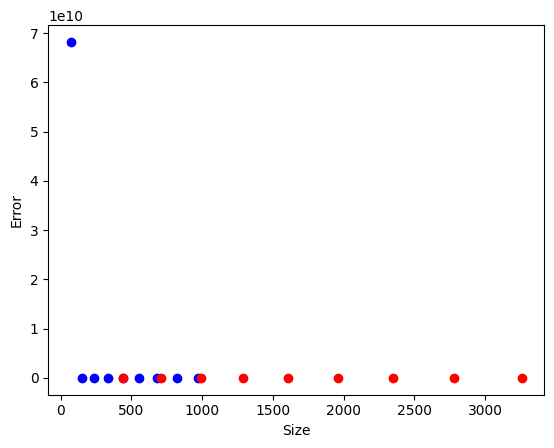

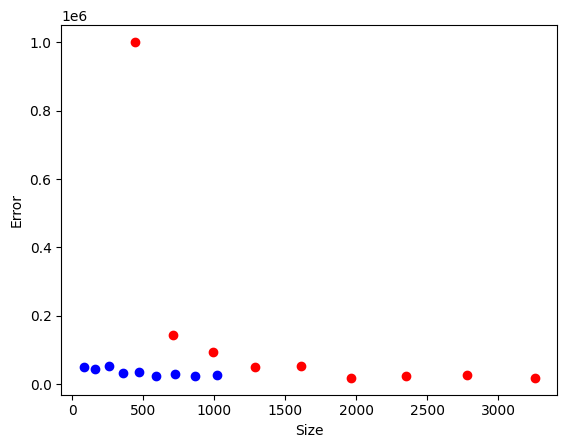

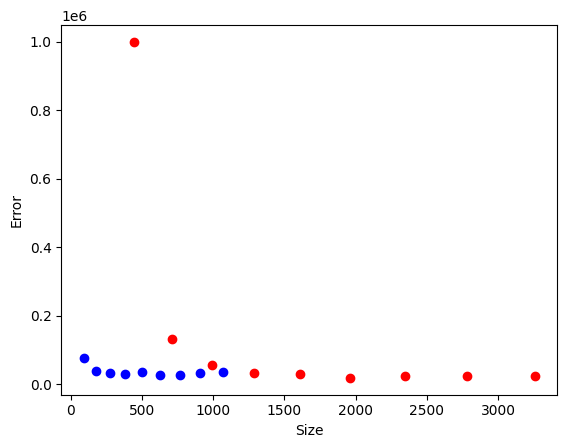

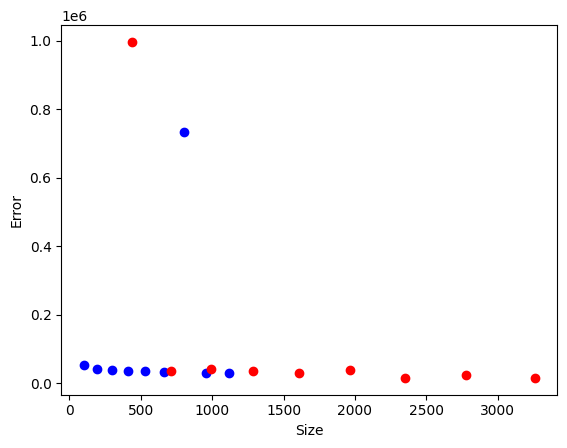

In [ ]:
# For a given input and output size, as size increases, error reduces
groups = lstmGrouped.groups.keys()
for g in groups:
    tmpdf1 = lstmGrouped.get_group(g)
    tmpdf2 = fourierGrouped.get_group(g)
    plt.plot(tmpdf1["Size"], tmpdf1["Error"], "bo")
    plt.plot(tmpdf2["Size"], tmpdf2["Error"], "ro")
    plt.plot()
    plt.xlabel("Size")
    plt.ylabel("Error")
    plt.show()
# tmpdf

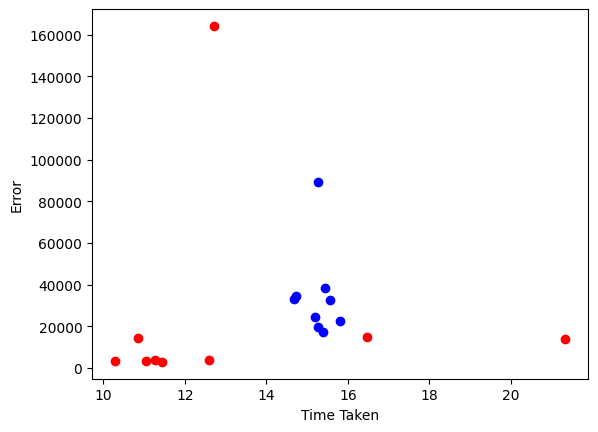

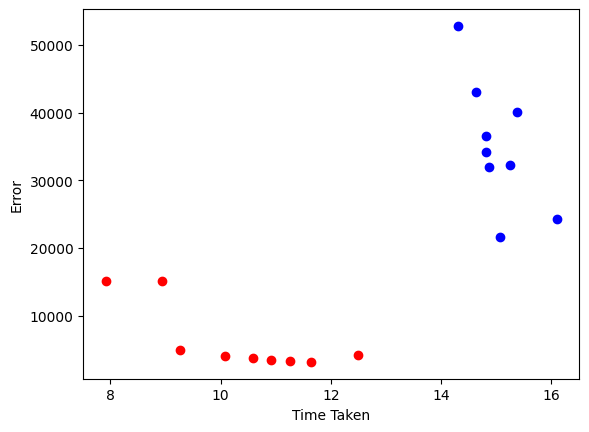

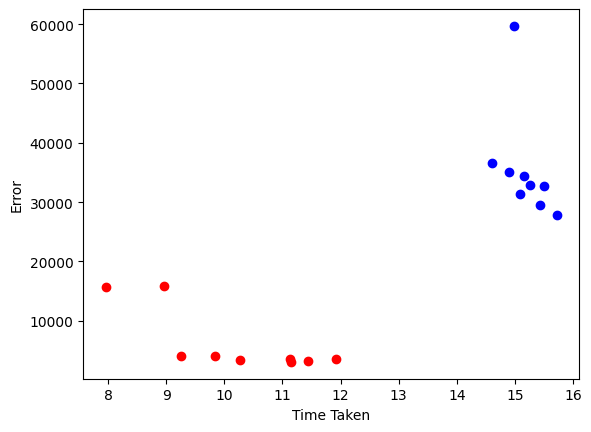

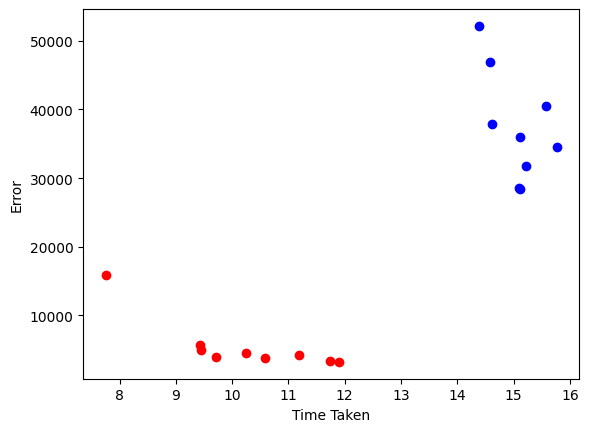

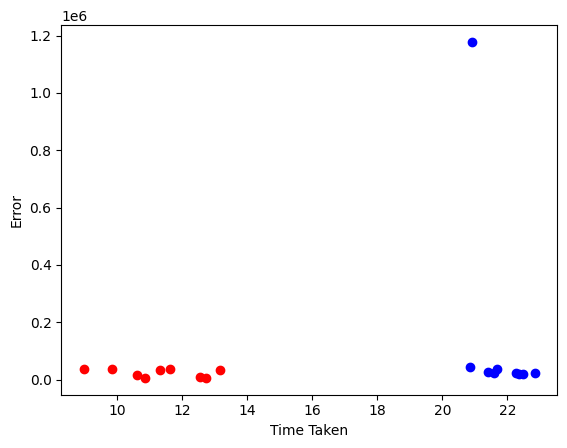

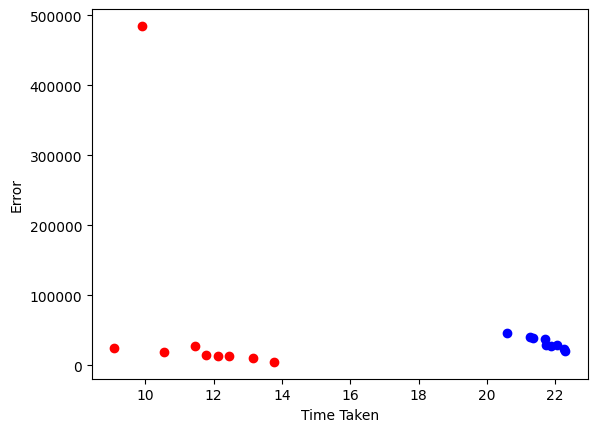

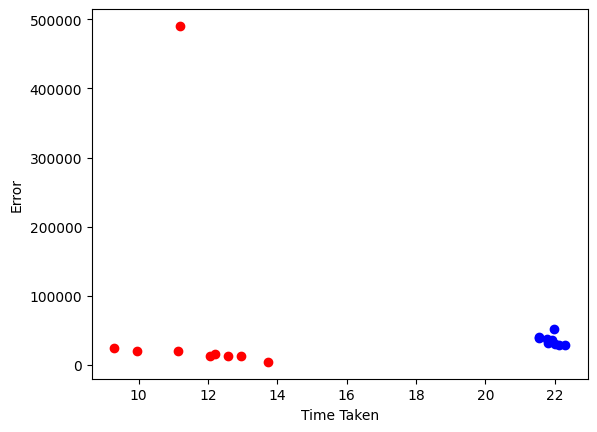

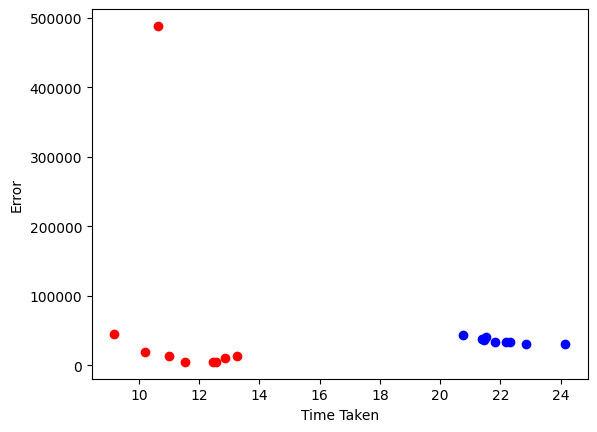

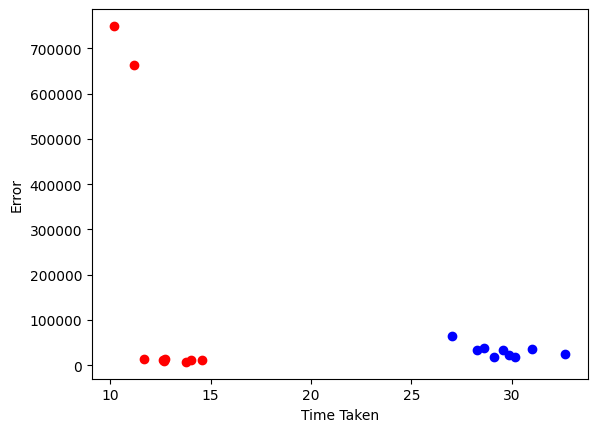

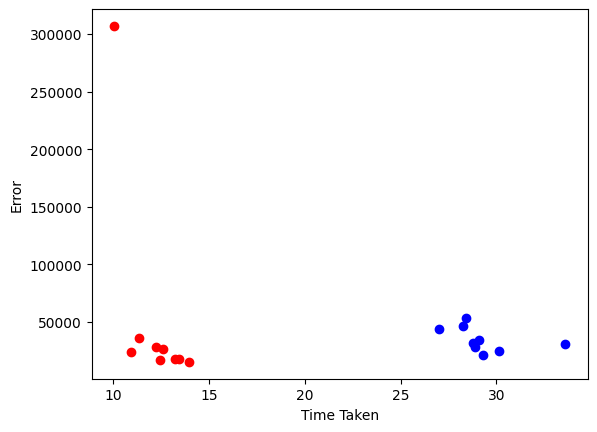

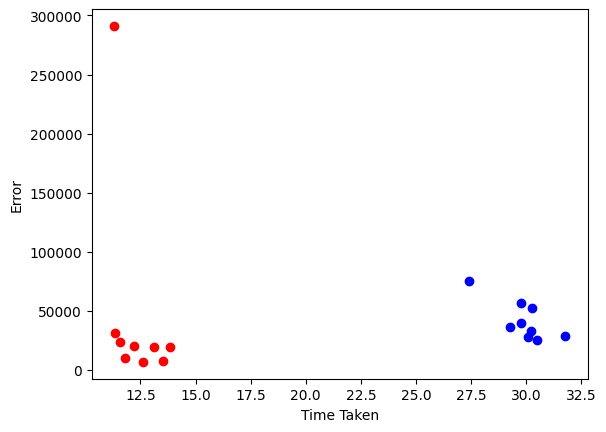

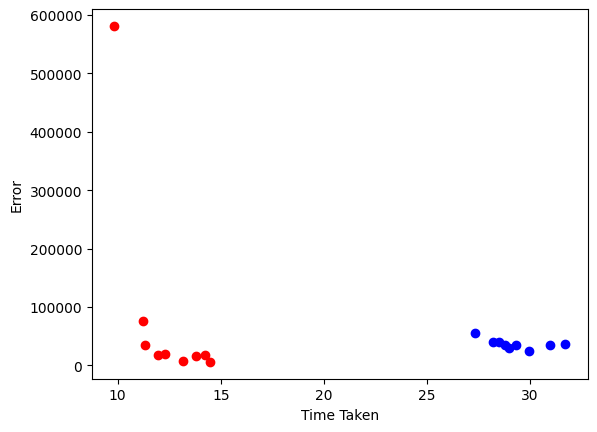

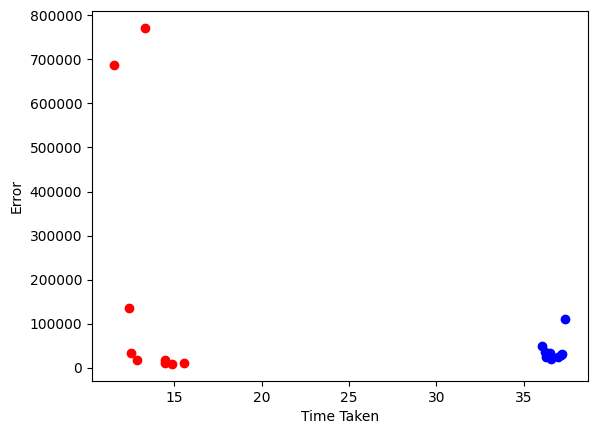

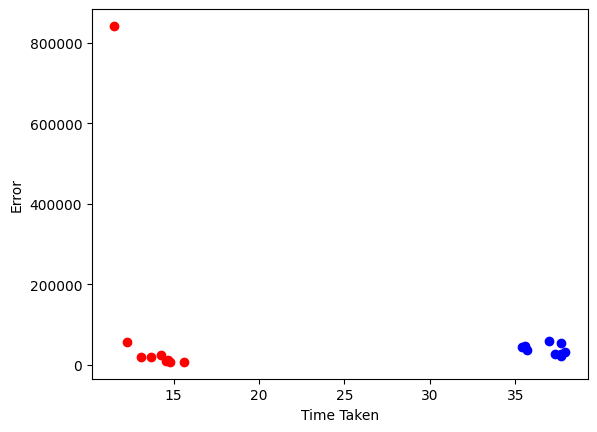

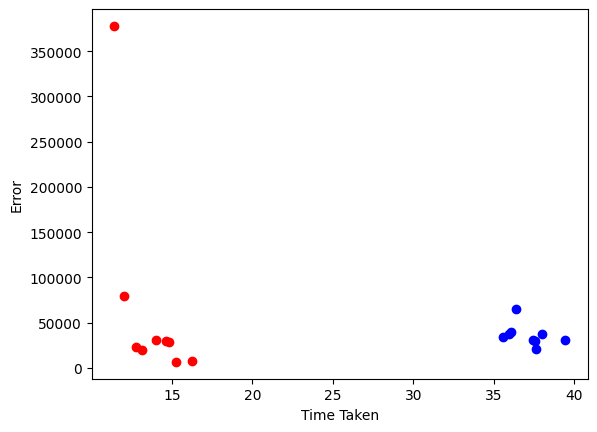

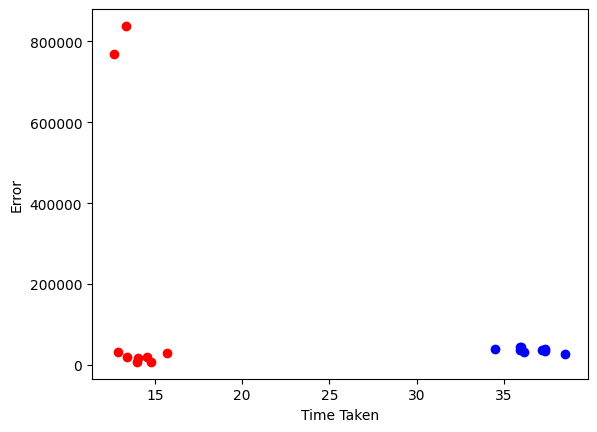

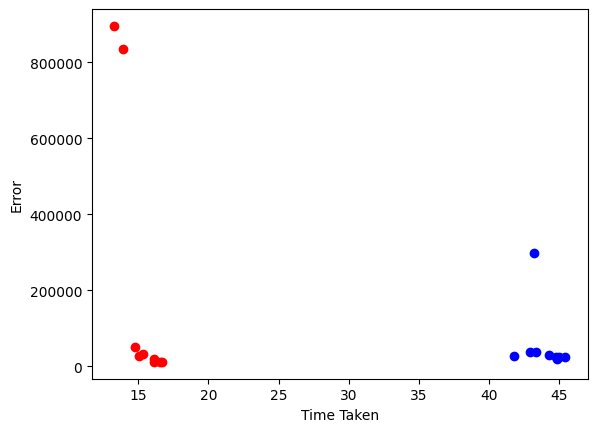

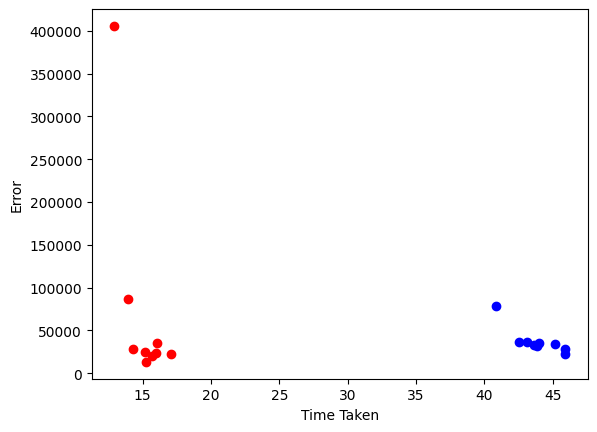

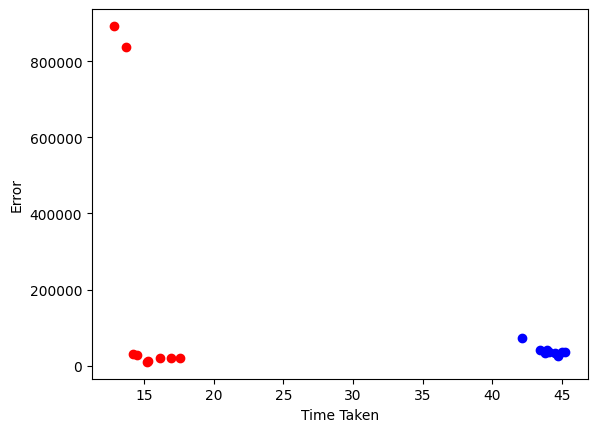

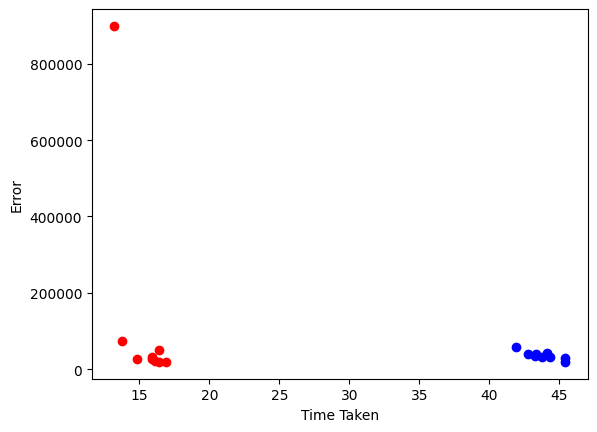

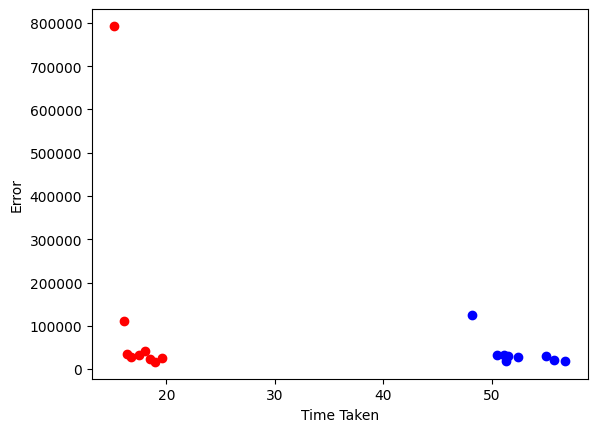

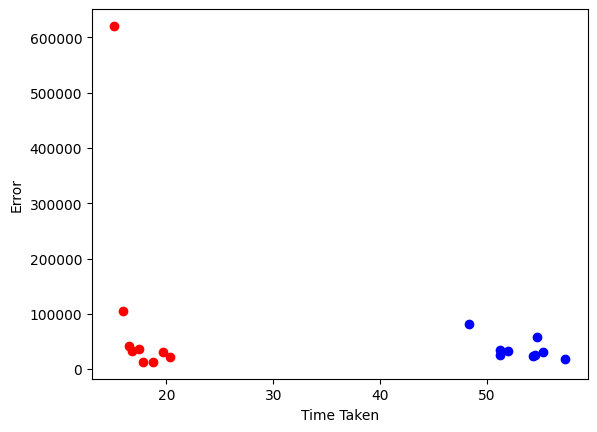

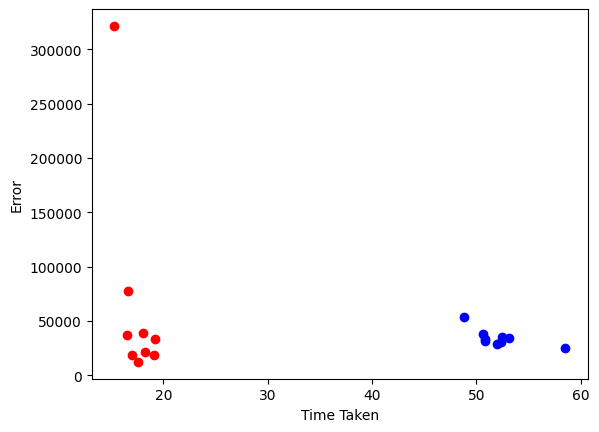

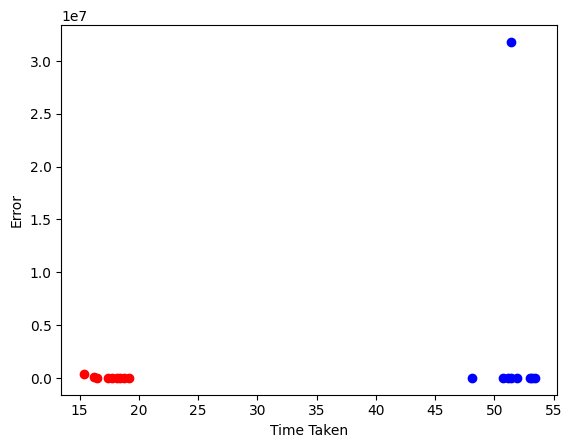

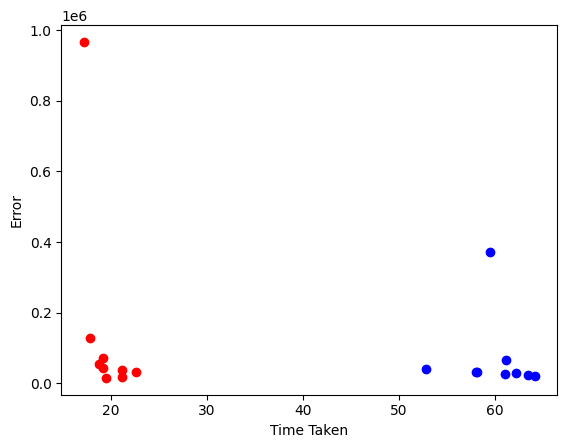

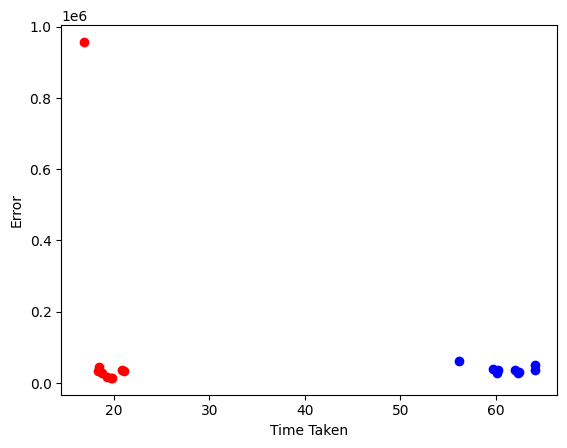

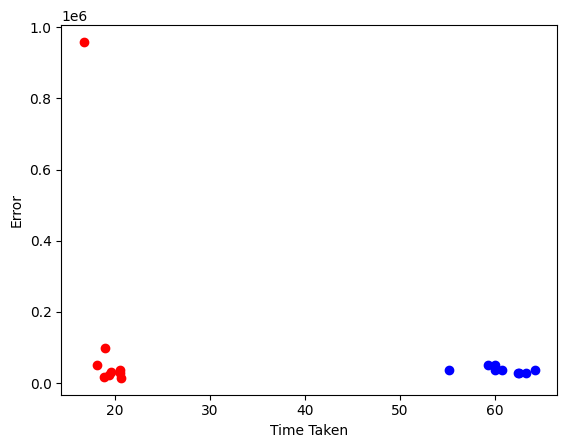

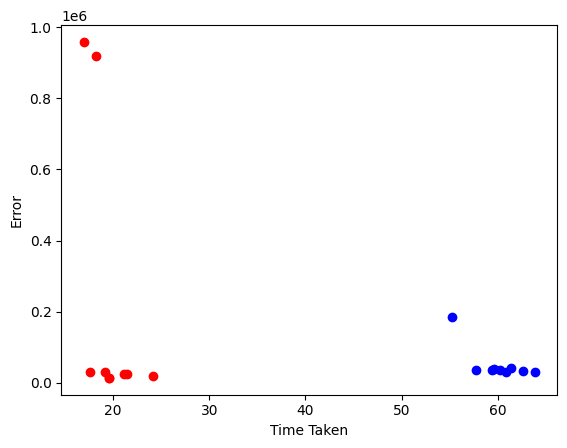

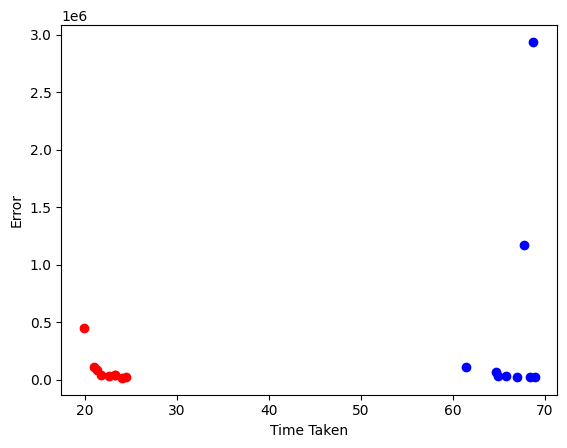

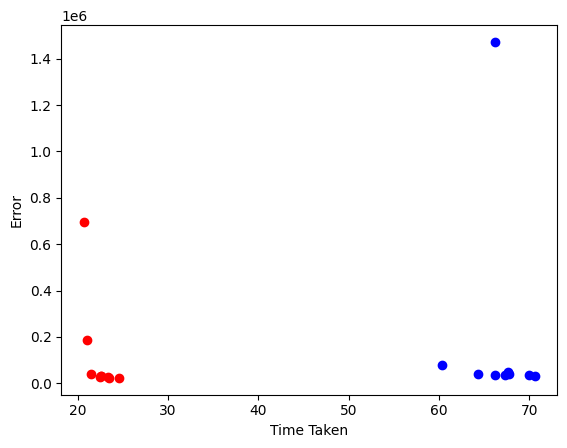

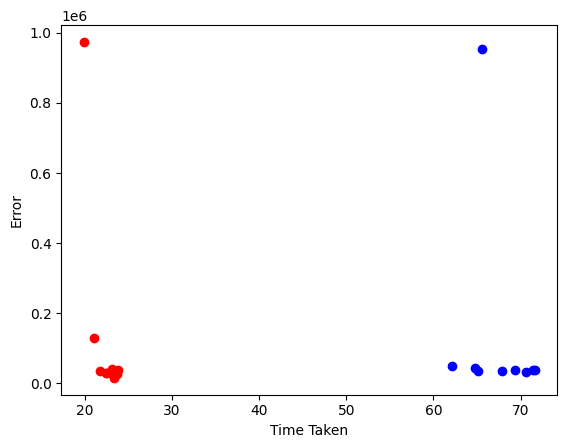

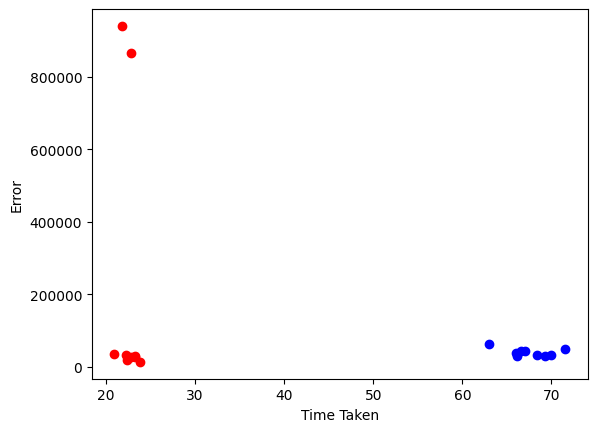

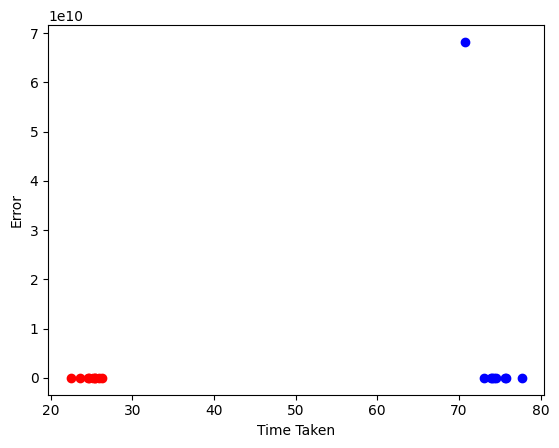

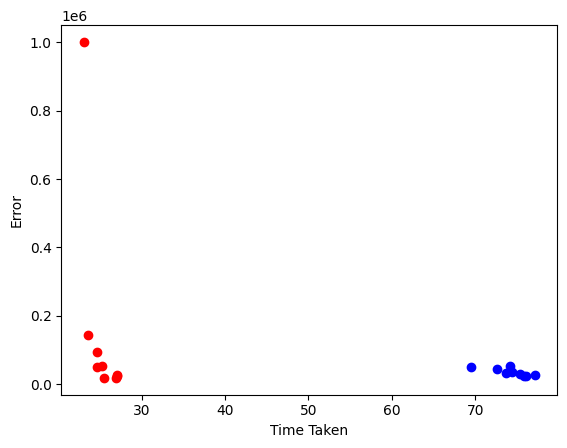

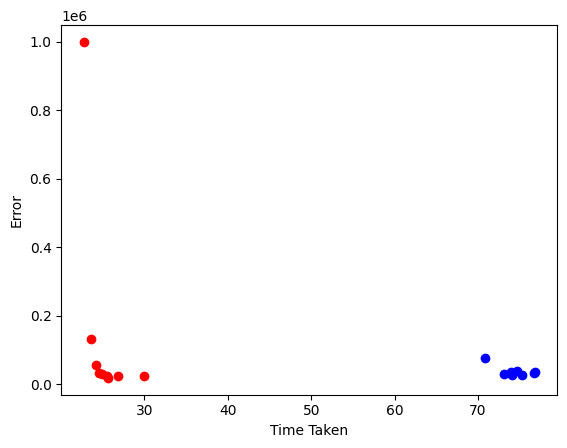

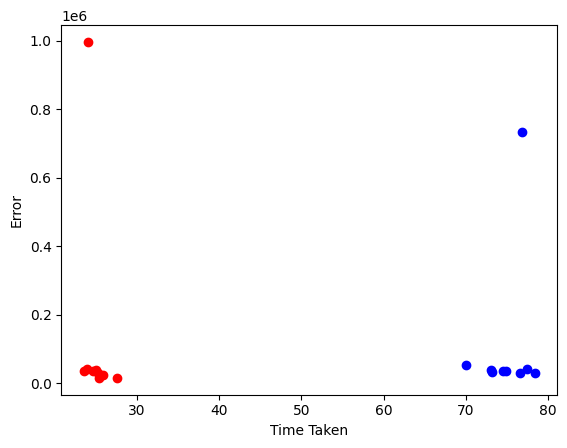

In [ ]:
# For a given input and output size, as size increases, error reduces
groups = lstmGrouped.groups.keys()
for g in groups:
    tmpdf1 = lstmGrouped.get_group(g)
    tmpdf2 = fourierGrouped.get_group(g)
    plt.plot(tmpdf1["TimeTaken"], tmpdf1["Error"], "bo")
    plt.plot(tmpdf2["TimeTaken"], tmpdf2["Error"], "ro")
    plt.plot()
    plt.xlabel("Time Taken")
    plt.ylabel("Error")
    plt.show()
# tmpdf

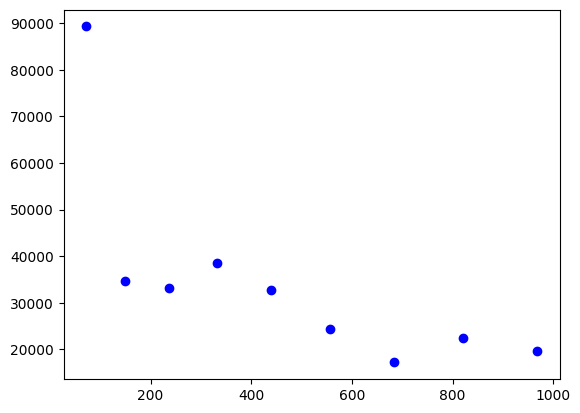

In [ ]:
plt.plot(tmpdf["Size"], tmpdf["Error"], "bo")

In [ ]:
outputs[0]["runs"][0].keys()

dict_keys(['expected', 'predicted', 'timeTaken', 'mse', 'num_params'])

In [ ]:
outputFiles = os.listdir("fourierResults")
outputs = None
with open("fourierResults/outputs_323_500.pkl", "rb") as f:
    outputs = pkl.load(f)
fourierData = {'WindowSize':[], 'ForecastHorizon':[], 'TimeTaken':[], 'Error':[], "Size": []}
for output in outputs:
    fourierData["WindowSize"].append(output["inputParameters"]["WindowSize"])
    fourierData["Size"].append(output["inputParameters"]["HiddenUnits"])
    fourierData["ForecastHorizon"].append(output["inputParameters"]["ForecastHorizon"])
    fourierData["TimeTaken"].append(output["runs"][0]["timeTaken"])
    fourierData["Error"].append(output["runs"][0]["mse"])

import pandas as pd

fourierDf = pd.DataFrame.from_dict(fourierData)

KeyError: 'num_params'

In [ ]:
tmpdf1 = fourierDf[["Size"]]

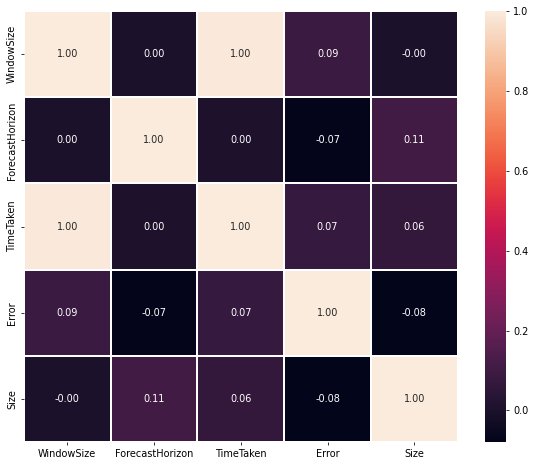

In [ ]:
# corr = lstmDf[lstmDf["Size"]==1].corr(method = 'pearson')
# Window  size strongly affects time taken
corr = lstmDf.corr(method='pearson')
plt.figure(figsize=(10,8), dpi=70)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [ ]:
# for same window and forecast horizon, fourier takes less time and smaller, with better or same performance
# for same window and forecast horizon, plot size vs performance, time vs performance

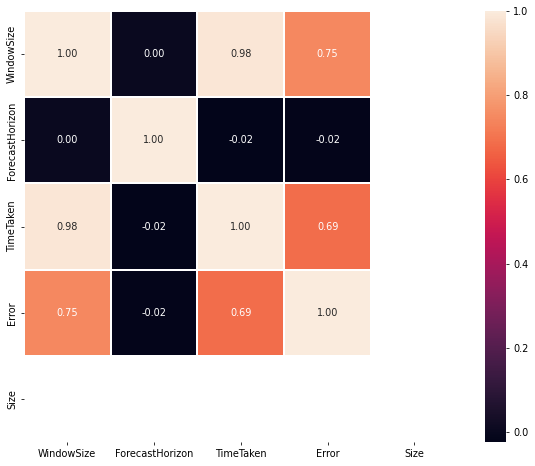

In [ ]:
corr = fourierDf[fourierDf["Size"]==1].corr(method = 'pearson')
plt.figure(figsize=(10,8), dpi=70)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [ ]:
import plotly.express as px
import time

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(fourierDf)
# scaledDf = pd.DataFrame(scaled_data, columns=fourierDf.columns)
# scaledDf

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaledDf = scaler.fit_transform(fourierDf)
scaledDf
averageDf = scaledDf.transpose().mean(axis=1)
# averageDf.shape
# averageDf


# averageDf = scaledDf.transpose().mean(axis=1)


t1 = time.time()
df00 = pd.DataFrame({'Col A': fourierDf.columns,
                   'Col B': averageDf})
fig = px.line_polar(df00, r='Col B', theta='Col A', line_close=True)
fig.show()
t2 = time.time()
print(t2-t1)

0.1196904182434082


In [ ]:
outputs = None
with open("lstmResults/outputs_323_500.pkl", "rb") as f:
    outputs = pkl.load(f)

In [ ]:
len(outputs[0]["runs"])

1

In [ ]:
print(outputs[0]["inputParameters"].keys(), outputs[0]["runs"][0].keys())

dict_keys(['WindowSize', 'ForecastHorizon', 'TrainRatio', 'ValRatio', 'LstmUnits', 'DenseUnits', 'Epochs']) dict_keys(['expected', 'predicted', 'timeTaken', 'mse'])


In [ ]:
data = {'WindowSize':[], 'ForecastHorizon':[], 'TimeTaken':[], 'Error':[], "Size": []}
for output in outputs:
    data["WindowSize"].append(output["inputParameters"]["WindowSize"])
    data["Size"].append(output["inputParameters"]["LstmUnits"])
    data["ForecastHorizon"].append(output["inputParameters"]["ForecastHorizon"])
    data["TimeTaken"].append(output["runs"][0]["timeTaken"])
    data["Error"].append(output["runs"][0]["mse"])


In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(data)

In [ ]:
df

WindowSize  ForecastHorizon  TimeTaken         Error  Size
0            10                5  14.620004  30478.164518     1
1            10                5  15.828974  40678.045833     2
2            10                5  20.001989  32004.273548     3
3            10                5  19.924316  30545.784419     4
4            10                5  18.020369  29465.102226     5
..          ...              ...        ...           ...   ...
319          90               20  73.393414  33381.841377     5
320          90               20  73.634135  35824.236183     6
321          90               20  75.312943  31113.005784     7
322          90               20  75.789378  24683.665934     8
323          90               20  77.166372  25568.835169     9

[324 rows x 5 columns]

In [ ]:
import seaborn as sns

In [ ]:
corr = df.corr(method = 'pearson')
corr

WindowSize  ForecastHorizon  TimeTaken     Error  \
WindowSize       1.000000e+00     4.655374e-16   0.995457  0.086822   
ForecastHorizon  4.655374e-16     1.000000e+00   0.004491 -0.033423   
TimeTaken        9.954574e-01     4.491173e-03   1.000000  0.086883   
Error            8.682221e-02    -3.342295e-02   0.086883  1.000000   
Size            -6.579099e-17     9.875957e-18   0.062630  0.009607   

                         Size  
WindowSize      -6.579099e-17  
ForecastHorizon  9.875957e-18  
TimeTaken        6.262957e-02  
Error            9.606818e-03  
Size             1.000000e+00

In [ ]:
corr = scaledDf.corr(method = 'pearson')
corr

WindowSize  ForecastHorizon  TimeTaken     Error  \
WindowSize       1.000000e+00     7.264422e-17   0.995457  0.086822   
ForecastHorizon  7.264422e-17     1.000000e+00   0.004491 -0.033423   
TimeTaken        9.954574e-01     4.491173e-03   1.000000  0.086883   
Error            8.682221e-02    -3.342295e-02   0.086883  1.000000   
Size             0.000000e+00    -3.015421e-17   0.062630  0.009607   

                         Size  
WindowSize       0.000000e+00  
ForecastHorizon -3.015421e-17  
TimeTaken        6.262957e-02  
Error            9.606818e-03  
Size             1.000000e+00

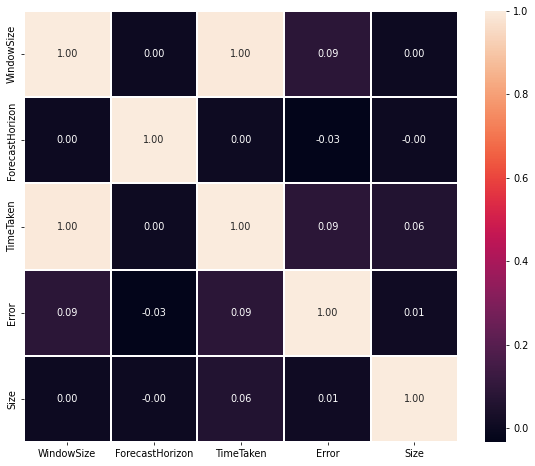

In [ ]:

plt.figure(figsize=(10,8), dpi=70)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

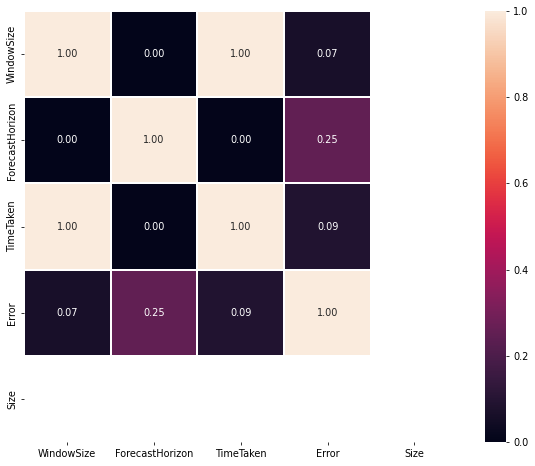

In [ ]:
corr = df[df["Size"]==1].corr(method = 'pearson')
plt.figure(figsize=(10,8), dpi=70)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaledDf = scaler.fit_transform(df)
# scaledDf
# averageDf = scaledDf.transpose().mean(axis=1)
# averageDf.shape
# averageDf


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaledDf = pd.DataFrame(scaled_data, columns=df.columns)
scaledDf
# averageDf = scaledDf.transpose().mean(axis=1)
# averageDf.shape
# averageDf


WindowSize  ForecastHorizon  TimeTaken     Error      Size
0     -1.549193        -1.341641  -1.521659 -0.074738 -1.549193
1     -1.549193        -1.341641  -1.458693 -0.074738 -1.161895
2     -1.549193        -1.341641  -1.241353 -0.074738 -0.774597
3     -1.549193        -1.341641  -1.245398 -0.074738 -0.387298
4     -1.549193        -1.341641  -1.344560 -0.074738  0.000000
..          ...              ...        ...       ...       ...
319    1.549193         1.341641   1.539391 -0.074738  0.000000
320    1.549193         1.341641   1.551928 -0.074738  0.387298
321    1.549193         1.341641   1.639364 -0.074738  0.774597
322    1.549193         1.341641   1.664178 -0.074738  1.161895
323    1.549193         1.341641   1.735895 -0.074738  1.549193

[324 rows x 5 columns]

In [ ]:
len(outputs)

324

In [ ]:
len(outputs[])

34

In [ ]:
df["cnt"] = np.ones(len(df))

pt = pd.pivot_table(df, values='cnt', index=['Group1'],
                  columns=['Vote'], aggfunc=np.sum)

fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

theta = np.arange(len(pt))/float(len(pt))*2.*np.pi
l1, = ax.plot(theta, pt["YES"], color="C2", marker="o", label="YES")
l2, = ax.plot(theta, pt["NO"], color="C3", marker="o", label="NO")

def _closeline(line):
    x, y = line.get_data()
    x = np.concatenate((x, [x[0]]))
    y = np.concatenate((y, [y[0]]))
    line.set_data(x, y)
[_closeline(l) for l in [l1,l2]]

ax.set_xticks(theta)
ax.set_xticklabels(pt.index)
plt.legend()
plt.title("How often have people votes Yes or No?")
plt.show()

In [ ]:
df00

Col A   Col B
0     home   6.797
1    other   3.243
2     used  12.567
3      new   8.985
4  service   1.345

In [ ]:
import plotly.express as px
import time
t1 = time.time()
df00 = pd.DataFrame({'Col A': df.columns,
                   'Col B': averageDf})
fig = px.line_polar(df00, r='Col B', theta='Col A', line_close=True)
fig.show()
t2 = time.time()
print(t2-t1)

0.042105674743652344
